In [17]:
FILE_PATH = "../data/superstore_dataset.csv"

In [18]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
import warnings

In [19]:
sales_raw = pd.read_csv(FILE_PATH)

In [20]:
sales_raw.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country/Region,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2020-152156,11/8/2020,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2020-152156,11/8/2020,11/11/2020,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2020-138688,6/12/2020,6/16/2020,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2019-108966,10/11/2019,10/18/2019,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2019-108966,10/11/2019,10/18/2019,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [21]:
sales_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          9994 non-null   int64  
 1   Order ID        9994 non-null   object 
 2   Order Date      9994 non-null   object 
 3   Ship Date       9994 non-null   object 
 4   Ship Mode       9994 non-null   object 
 5   Customer ID     9994 non-null   object 
 6   Customer Name   9994 non-null   object 
 7   Segment         9994 non-null   object 
 8   Country/Region  9994 non-null   object 
 9   City            9994 non-null   object 
 10  State           9994 non-null   object 
 11  Postal Code     9983 non-null   float64
 12  Region          9994 non-null   object 
 13  Product ID      9994 non-null   object 
 14  Category        9994 non-null   object 
 15  Sub-Category    9994 non-null   object 
 16  Product Name    9994 non-null   object 
 17  Sales           9994 non-null   f

In [22]:
sales_raw.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9983.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55245.233297,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32038.715955,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,57103.000000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


### Observations:

##### • There are 9994 instances with 21 features.
##### • Dates are in DD/MM/YYYY format.
##### • Features are mostly object, with four float64 and two int64 features. Datetime columns need to be converted accordingly.

We'll drop the Postal code column as for sales prediction focus it's not necessary, still we'll save a copy just in case.

In [23]:
sales = sales_raw.copy()
sales = sales.drop("Postal Code", axis = 1) #axis=1 for column
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row ID          9994 non-null   int64  
 1   Order ID        9994 non-null   object 
 2   Order Date      9994 non-null   object 
 3   Ship Date       9994 non-null   object 
 4   Ship Mode       9994 non-null   object 
 5   Customer ID     9994 non-null   object 
 6   Customer Name   9994 non-null   object 
 7   Segment         9994 non-null   object 
 8   Country/Region  9994 non-null   object 
 9   City            9994 non-null   object 
 10  State           9994 non-null   object 
 11  Region          9994 non-null   object 
 12  Product ID      9994 non-null   object 
 13  Category        9994 non-null   object 
 14  Sub-Category    9994 non-null   object 
 15  Product Name    9994 non-null   object 
 16  Sales           9994 non-null   float64
 17  Quantity        9994 non-null   i

In [24]:
#convert datetime columns to datetime objects
sales['Order Date'] = pd.to_datetime(sales['Order Date'], dayfirst=True)
sales['Ship Date'] = pd.to_datetime(sales['Ship Date'], dayfirst=True)
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Row ID          9994 non-null   int64         
 1   Order ID        9994 non-null   object        
 2   Order Date      9994 non-null   datetime64[ns]
 3   Ship Date       9994 non-null   datetime64[ns]
 4   Ship Mode       9994 non-null   object        
 5   Customer ID     9994 non-null   object        
 6   Customer Name   9994 non-null   object        
 7   Segment         9994 non-null   object        
 8   Country/Region  9994 non-null   object        
 9   City            9994 non-null   object        
 10  State           9994 non-null   object        
 11  Region          9994 non-null   object        
 12  Product ID      9994 non-null   object        
 13  Category        9994 non-null   object        
 14  Sub-Category    9994 non-null   object        
 15  Prod

/var/folders/r0/6jmmwyrj56123vb9rjqcjc6r0000gn/T/ipykernel_5426/1387693867.py:2: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales['Order Date'] = pd.to_datetime(sales['Order Date'], dayfirst=True)
/var/folders/r0/6jmmwyrj56123vb9rjqcjc6r0000gn/T/ipykernel_5426/1387693867.py:3: UserWarning: Parsing dates in MM/DD/YYYY format when dayfirst=True was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  sales['Ship Date'] = pd.to_datetime(sales['Ship Date'], dayfirst=True)


In [25]:
#Get only order date, sales, and profit
sales = sales.loc[:, ["Order Date", "Sales", "Profit"]]

#Set date column to index
sales.set_index('Order Date', inplace = True)

In [26]:
#confirm we have a Datetime series object
print(sales.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9994 entries, 2020-08-11 to 2021-04-05
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sales   9994 non-null   float64
 1   Profit  9994 non-null   float64
dtypes: float64(2)
memory usage: 234.2 KB
None


# EDA

### Raw Visualization

#### Visualizing sales and profit from 2018 to 2021

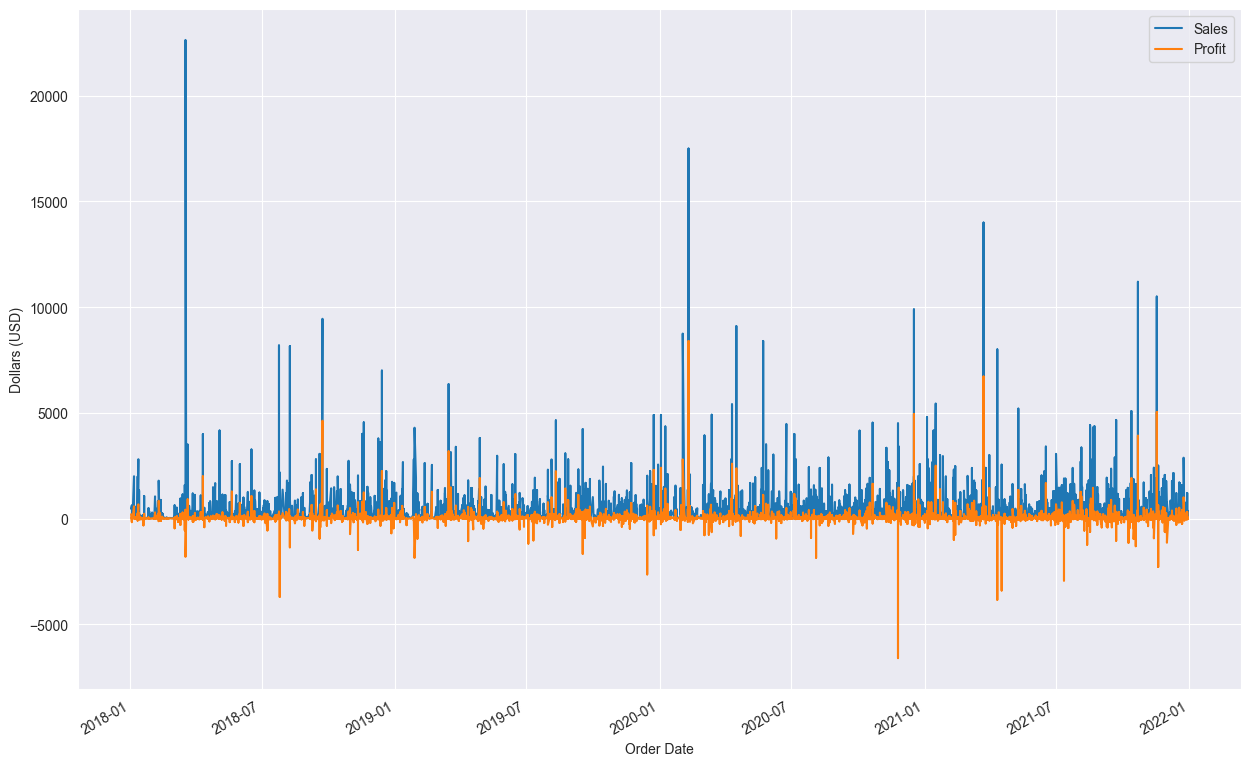

In [27]:
ax = sales.plot()
plt.gcf().set_size_inches(15, 10)
ax.set_ylabel("Dollars (USD)")
plt.show()

##### Let's compare data year by year overlapping the time series data:

#### Observations

##### • It is difficult to read raw visualisations and yearly overlap. To make it better, more work will be required. Working with rolling averages and adjusting the time series period's frequency could be beneficial.

### Frequency Optimization

It is pretty challenging to see anything on these plots. At the very least, let's consolidate Sales and Profits data from each day.

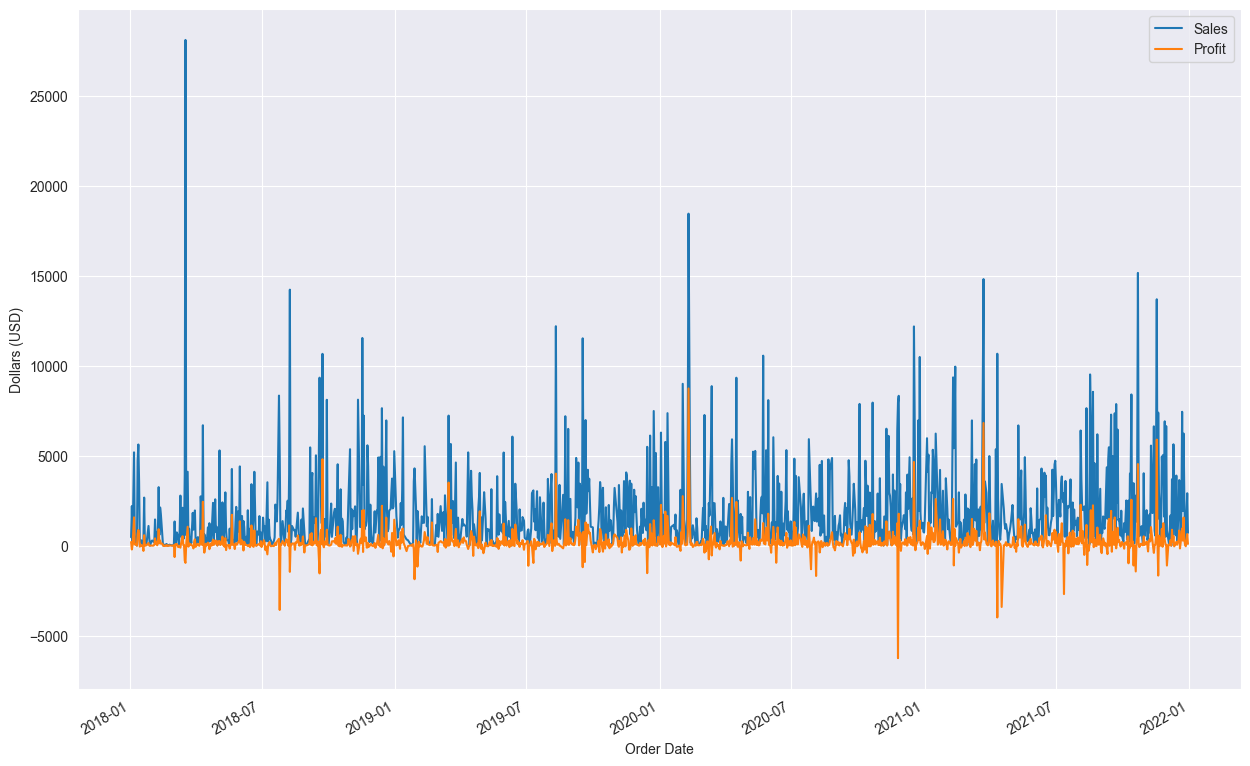

In [29]:
sales.plot()
plt.ylabel("Dollars (USD)")
plt.gcf().set_size_inches(15, 10)
plt.show()

In [32]:
#Create empty dataframe to store yearly data
sales_by_year = pd.DataFrame()

for year in ["2018", "2019", "2020", "2021"]:
    temp_year = sales.loc[year, ["Sales"]].reset_index(drop = True)
    temp_year.rename(columns={"Sales": year}, inplace = True)
    sales_by_year = pd.concat([sales_by_year, temp_year], axis=1)

sales_by_year

,2018,2019,2020,2021
0,468.900,1642.1744,161.970,1481.8280
1,2203.151,450.9400,6285.806,5972.9880
2,119.888,834.1980,2161.480,4108.3700
3,5188.520,1011.6960,517.866,5058.3620
4,601.024,2367.5640,1724.376,639.8300
...,...,...,...,...
317,NaN,NaN,773.774,814.5940
318,NaN,NaN,731.768,177.6360
319,NaN,NaN,NaN,1657.3508
320,NaN,NaN,NaN,2915.5340


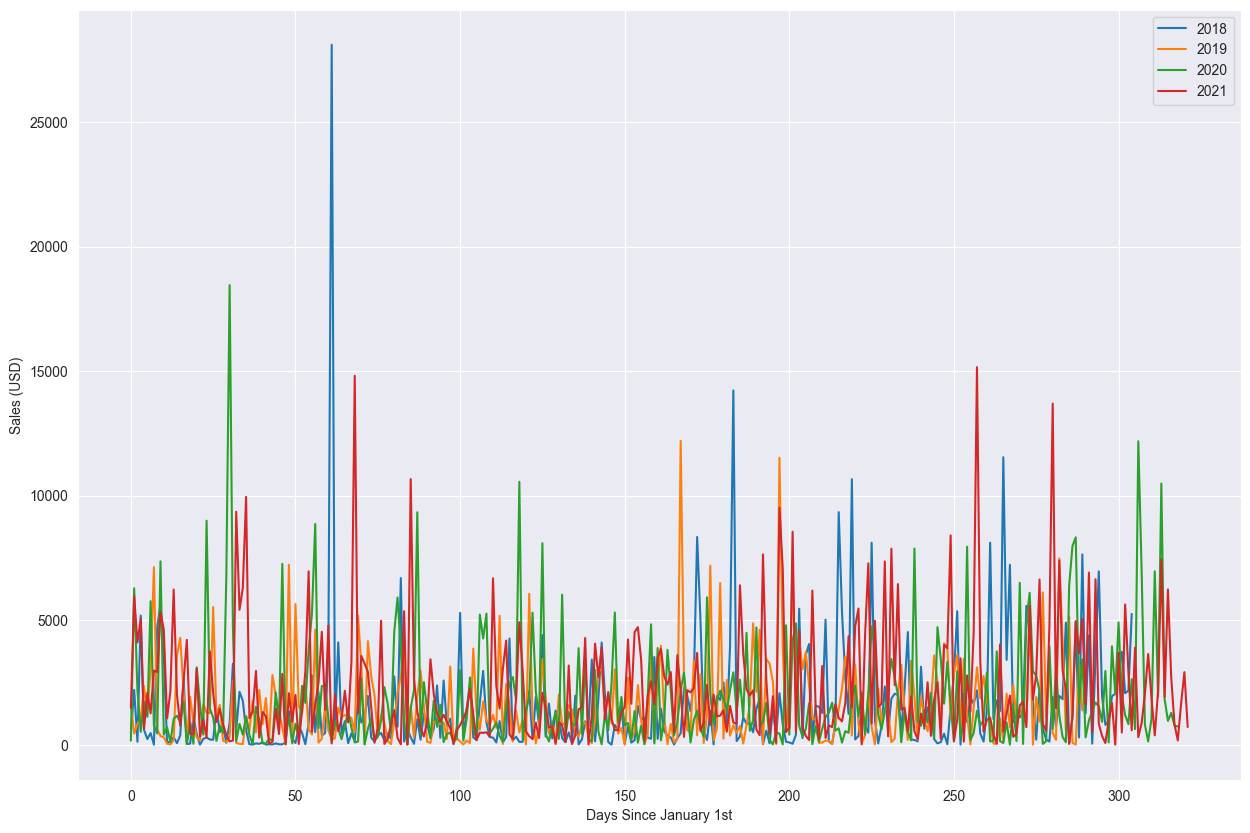

In [33]:
sales_by_year.plot()
plt.gcf().set_size_inches(15, 10)
plt.ylabel("Sales (USD)")
plt.xlabel("Days Since January 1st")
plt.show()

##### Still challenging to comprehend is the daily frequency D plot of the sales data. The frequency of MS at the beginning of the month substantially enhances readability. We'll also mention the YS frequency at the beginning of the year:

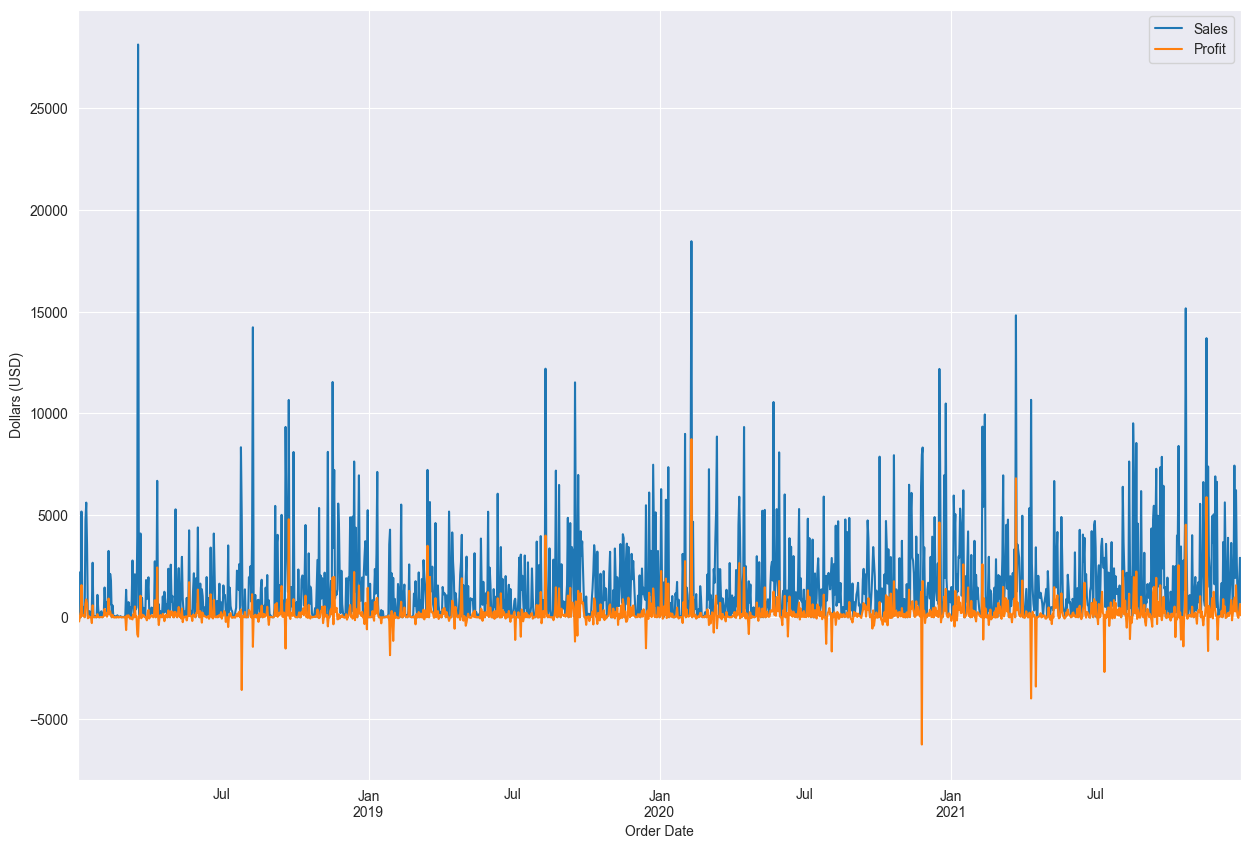

In [34]:
daily_sales = sales.groupby(pd.Grouper(freq='D')).sum()
daily_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.ylabel("Dollars (USD)")
plt.show()

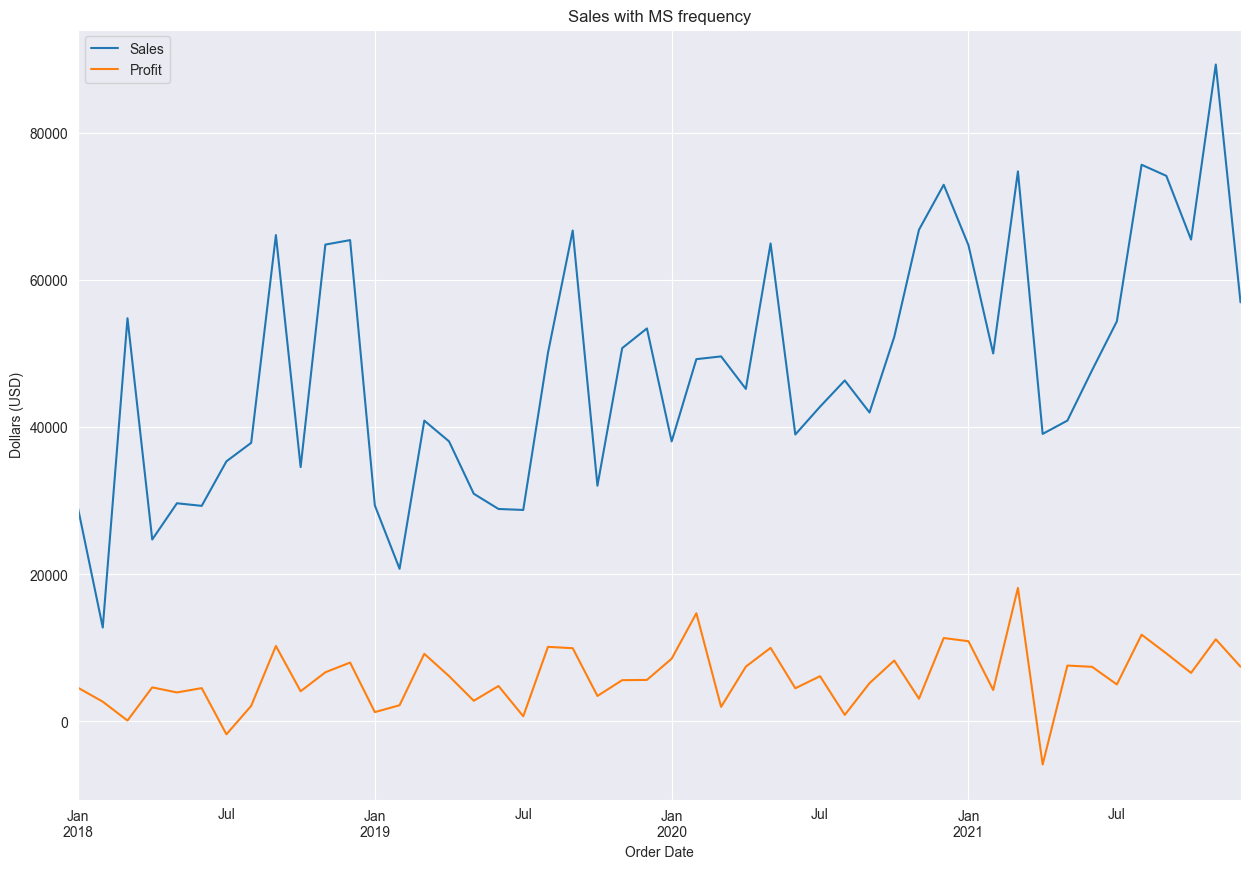

In [35]:
monthly_sales = sales.groupby(pd.Grouper(freq='MS')).sum()
monthly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales with MS frequency")
plt.ylabel("Dollars (USD)")
plt.show()

In [37]:
yearly_sales = sales.groupby(pd.Grouper(freq='YS')).sum()
yearly_sales

,Sales,Profit
Order Date,,
2018-01-01,484247.4981,49543.9741
2019-01-01,470532.5090,61618.6037
2020-01-01,609205.5980,81795.1743
2021-01-01,733215.2552,93439.2696


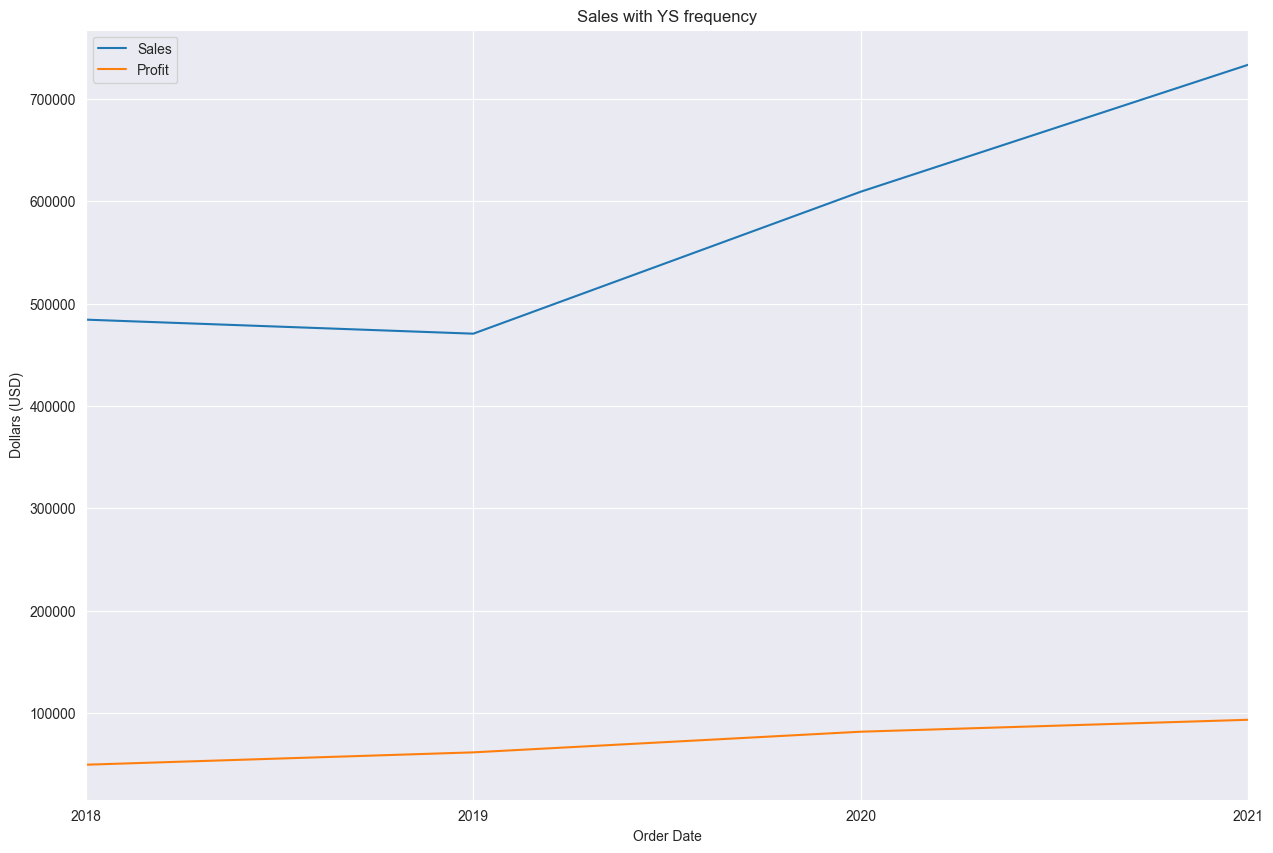

In [38]:
yearly_sales.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales with YS frequency")
plt.ylabel("Dollars (USD)")
plt.show()

##### Let's revisit the year-by-year overlap figure by with the monthly data instead:

In [39]:
#Create empty dataframe to store yearly data
monthly_sales_by_year = pd.DataFrame()

for year in ["2018", "2019", "2020", "2021"]:
    temp_year = monthly_sales.loc[year, ["Sales"]].reset_index(drop = True)
    temp_year.rename(columns={"Sales": year}, inplace = True)
    monthly_sales_by_year = pd.concat([monthly_sales_by_year, temp_year], axis=1)

monthly_sales_by_year

,2018,2019,2020,2021
0,28953.7060,29347.3864,38048.1840,64734.3110
1,12743.1080,20728.3520,49238.4100,50011.4894
2,54801.9060,40876.6112,49612.0450,74774.0838
3,24710.0160,38056.9685,45192.2780,39072.0016
4,29639.8340,30933.7145,64964.3218,40882.4464
5,29287.0306,28862.1982,38991.9430,47742.3255
6,35341.2460,28730.3760,42773.3950,54382.0875
7,37854.5475,50094.5280,46339.9884,75675.3040
8,66110.2238,66729.3290,41985.1423,74164.6080
9,34561.9470,32025.0750,52268.1500,65501.1622


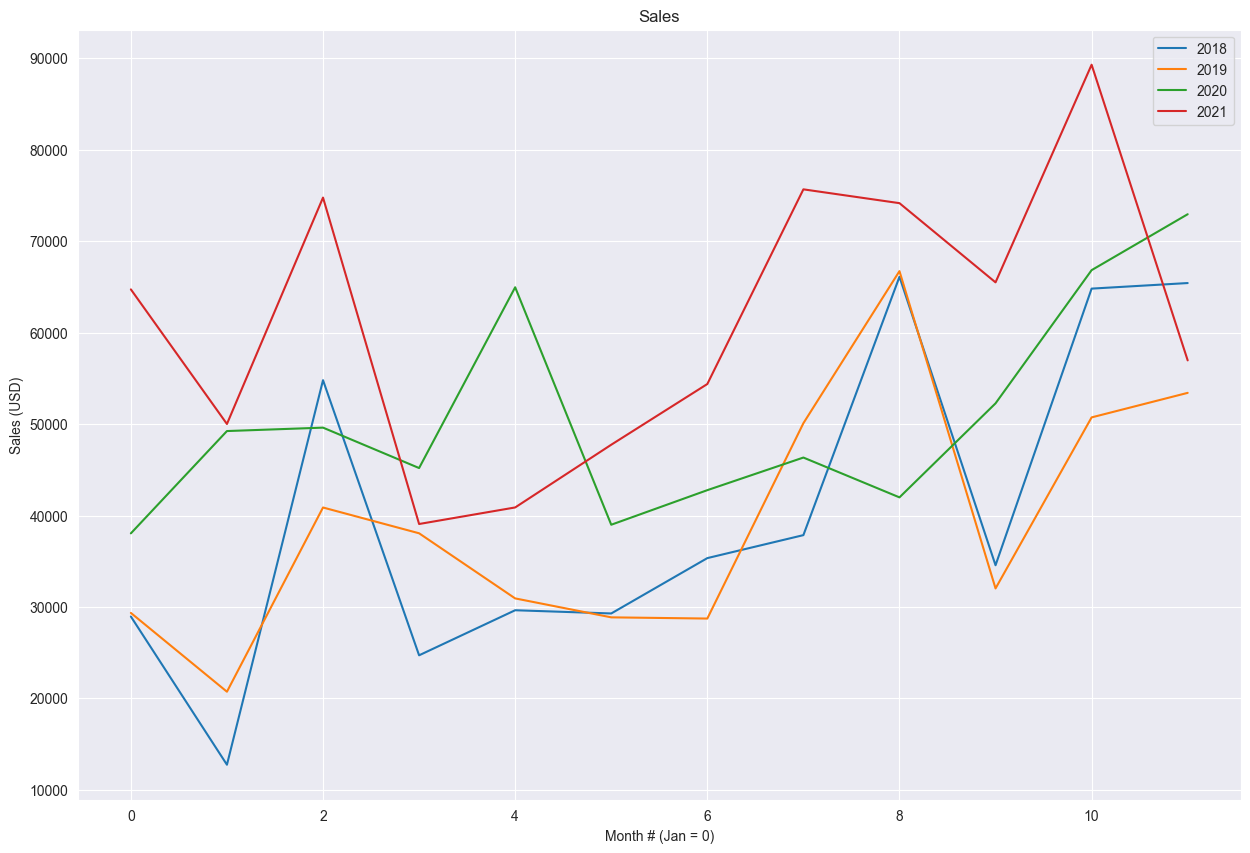

In [41]:
monthly_sales_by_year.plot()
plt.gcf().set_size_inches(15, 10)
plt.title("Sales")
plt.ylabel("Sales (USD)")
plt.xlabel("Month # (Jan = 0)")
plt.show()

#### Observations

1. There certainly seem to be annual peaks in the months of 2, 4, 8, and 11–12. Due to the way Python handles indices, these correlate to the 6th, 9th, and 12th months of the year, which are June, September, and November-December.
2. This may be due to the start of buying things for summer months as well as school supplies shopping and holiday shopping in the winter.
3. The frequency of month appears best, with daily being too noisy and yearly being too simple. To ensure this is the best data, we'll look at rolling averages as well.

#### Rolling Averages

The daily data is still quite difficult to visualize. It might be best to do a rolling average. Let's plot the daily sales and a 7-day rolling average:

/var/folders/r0/6jmmwyrj56123vb9rjqcjc6r0000gn/T/ipykernel_5426/3842312617.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x = sales.index, y = '7D_sales', data = sales, label = 'Rolling Average', palette=['r'])


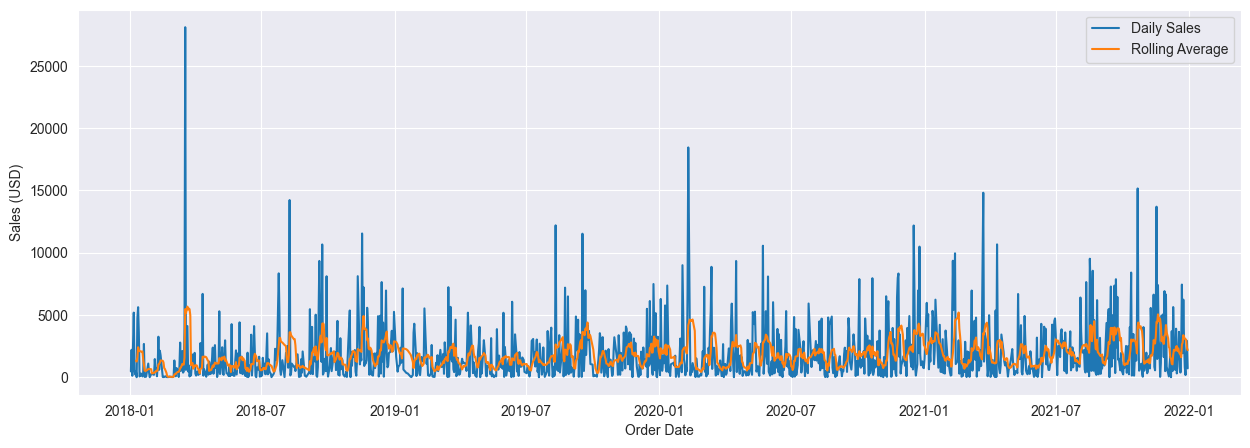

In [44]:
sales['7D_sales'] = sales.Sales.rolling(7).mean()
sales['7D_profit'] = sales.Profit.rolling(7).mean()
plt.gcf().set_size_inches(15, 5)
sns.lineplot(x = sales.index, y = 'Sales', data = sales, label = 'Daily Sales')
sns.lineplot(x = sales.index, y = '7D_sales', data = sales, label = 'Rolling Average', palette=['r'])
plt.ylabel("Sales (USD)")
plt.show()

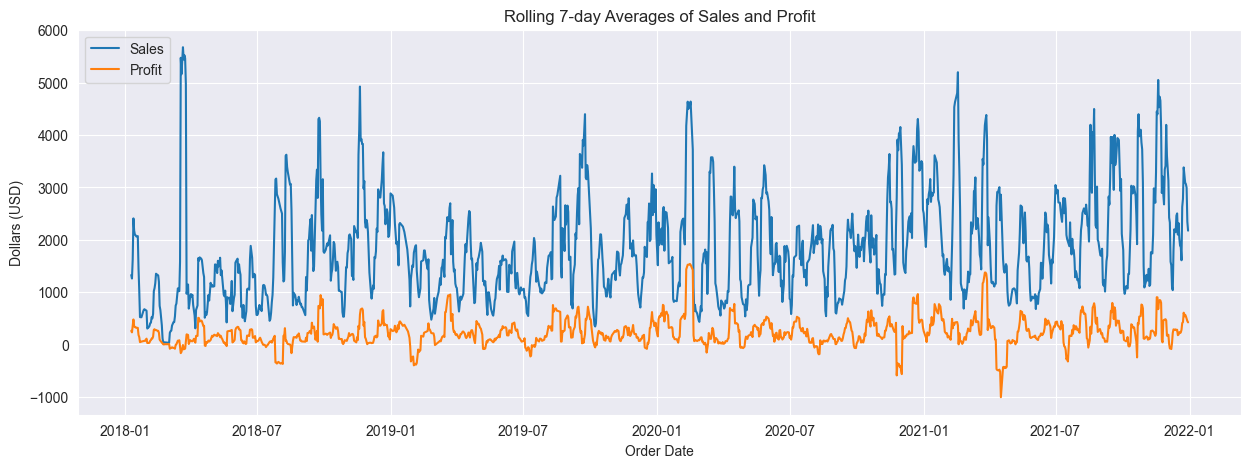

In [45]:
plt.gcf().set_size_inches(15, 5)
sns.lineplot(x = sales.index, y = '7D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '7D_profit', data = sales, label = 'Profit')

plt.title("Rolling 7-day Averages of Sales and Profit")
plt.ylabel("Dollars (USD)")
plt.show()

Let's see if a 30-day rolling average improves the readability:

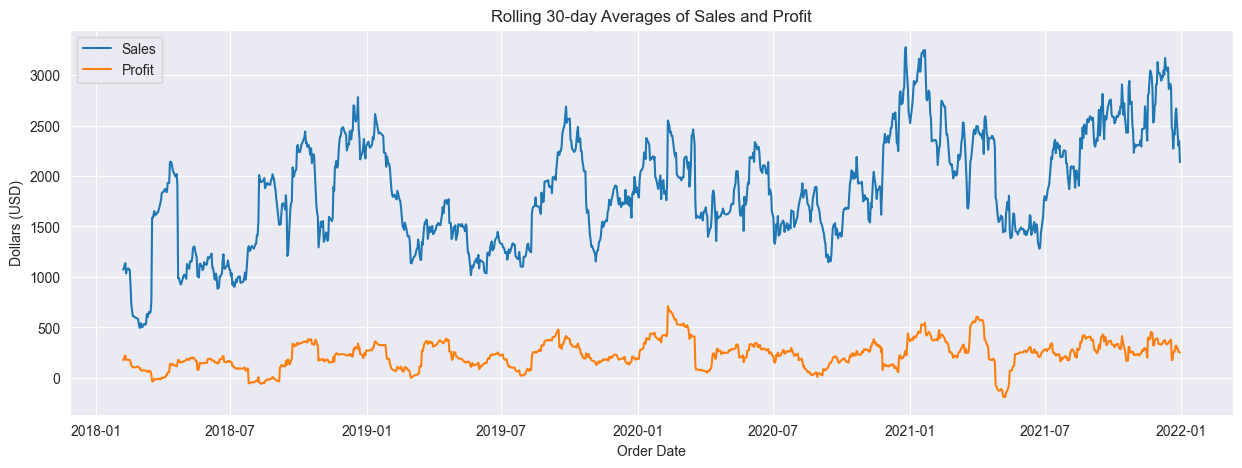

In [46]:
sales['30D_sales'] = sales.Sales.rolling(30).mean()
sales['30D_profit'] = sales.Profit.rolling(30).mean()

sns.lineplot(x = sales.index, y = '30D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '30D_profit', data = sales, label = 'Profit')

plt.title("Rolling 30-day Averages of Sales and Profit")
plt.gcf().set_size_inches(15, 5)
plt.ylabel("Dollars (USD)")
plt.show()

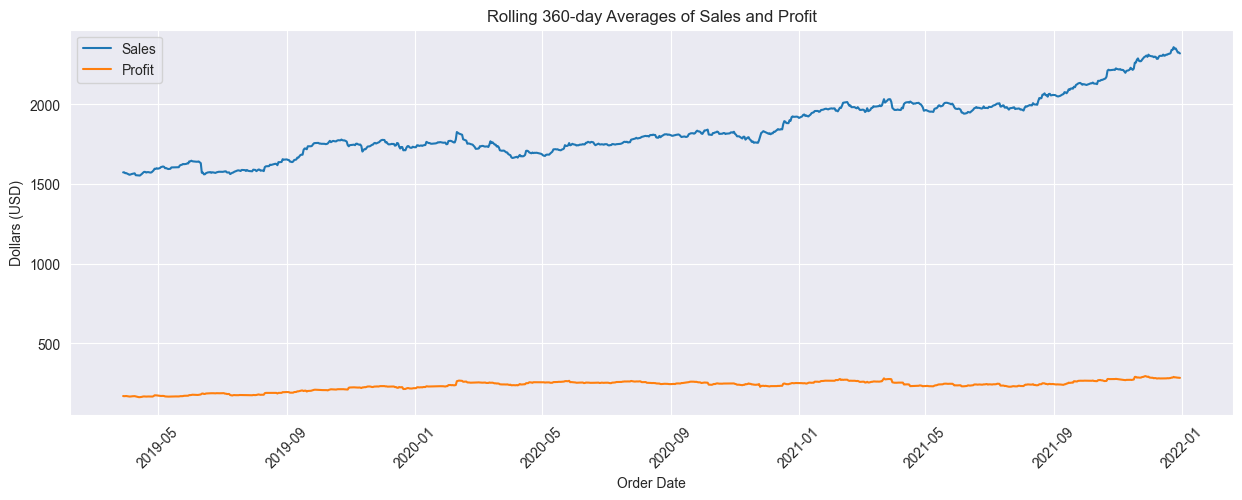

In [47]:
sales['360D_sales'] = sales.Sales.rolling(365).mean()
sales['360D_profit'] = sales.Profit.rolling(365).mean()

sns.lineplot(x = sales.index, y = '360D_sales', data = sales, label = 'Sales')
sns.lineplot(x = sales.index, y = '360D_profit', data = sales, label = 'Profit')

plt.title("Rolling 360-day Averages of Sales and Profit")
plt.gcf().set_size_inches(15, 5)
plt.ylabel("Dollars (USD)")
plt.xticks(rotation=45)
plt.show()

It may appear that profit is stagnant over this time period, however when splitting the data into subplots, it's clear that profit is increasing, however not nearly at the scale of sales:

/var/folders/r0/6jmmwyrj56123vb9rjqcjc6r0000gn/T/ipykernel_5426/3325411330.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax = axes[1], x = sales.index, y = '360D_profit', data = sales, label = 'Profit', palette='r')


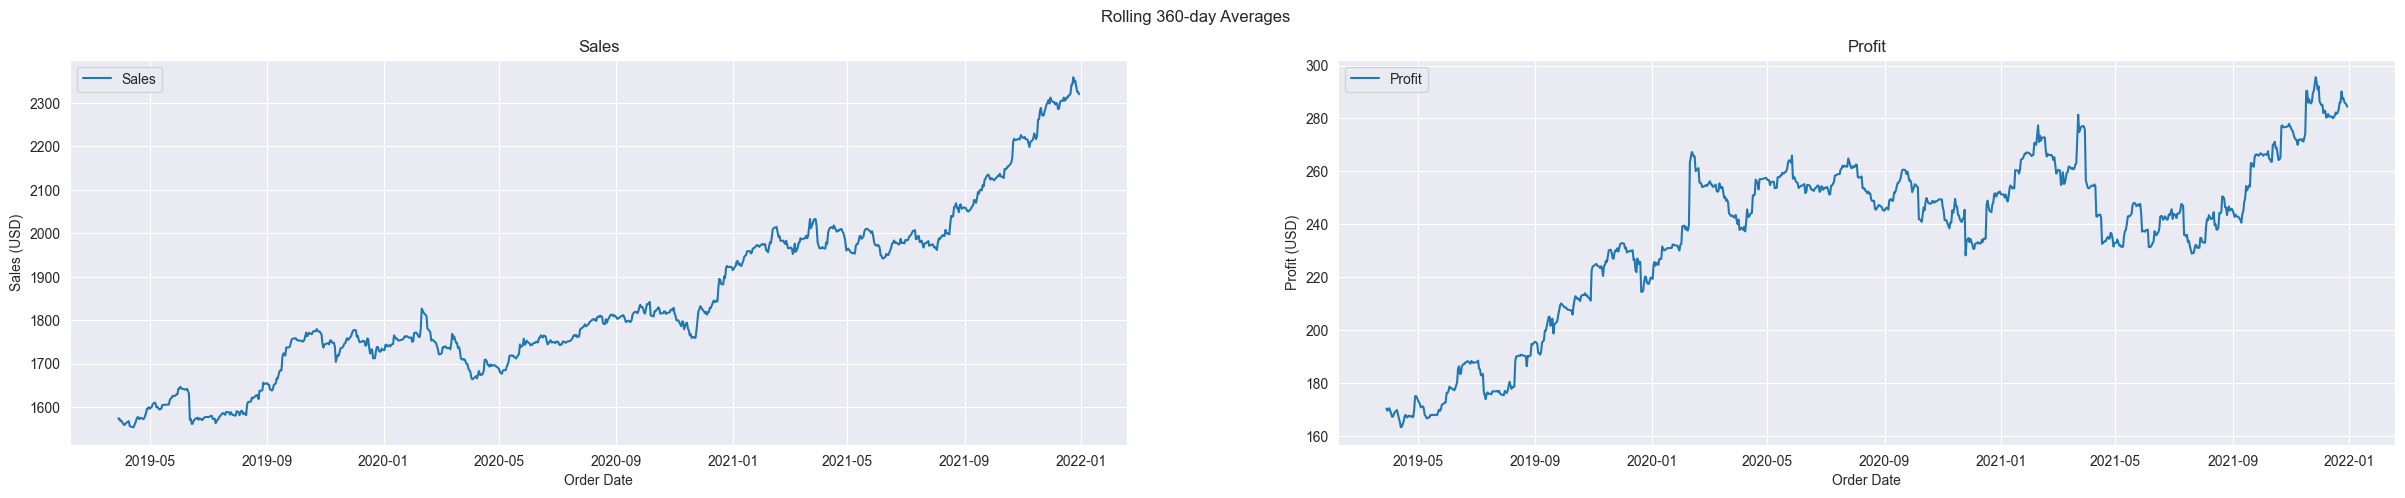

In [48]:
fig, axes = plt.subplots(1, 2)

sns.lineplot(ax = axes[0], x = sales.index, y = '360D_sales', data = sales, label = 'Sales', )
sns.lineplot(ax = axes[1], x = sales.index, y = '360D_profit', data = sales, label = 'Profit', palette='r')

fig.suptitle('Rolling 360-day Averages')
plt.gcf().set_size_inches(30, 5)
plt.subplots_adjust(hspace=0.5)
axes[0].set_title('Sales')
axes[1].set_title('Profit')
axes[0].set_ylabel("Sales (USD)")
axes[1].set_ylabel("Profit (USD)")
plt.show()

It is useful to see the distribution of the rolling average to see how volatile the sales time series actually is:

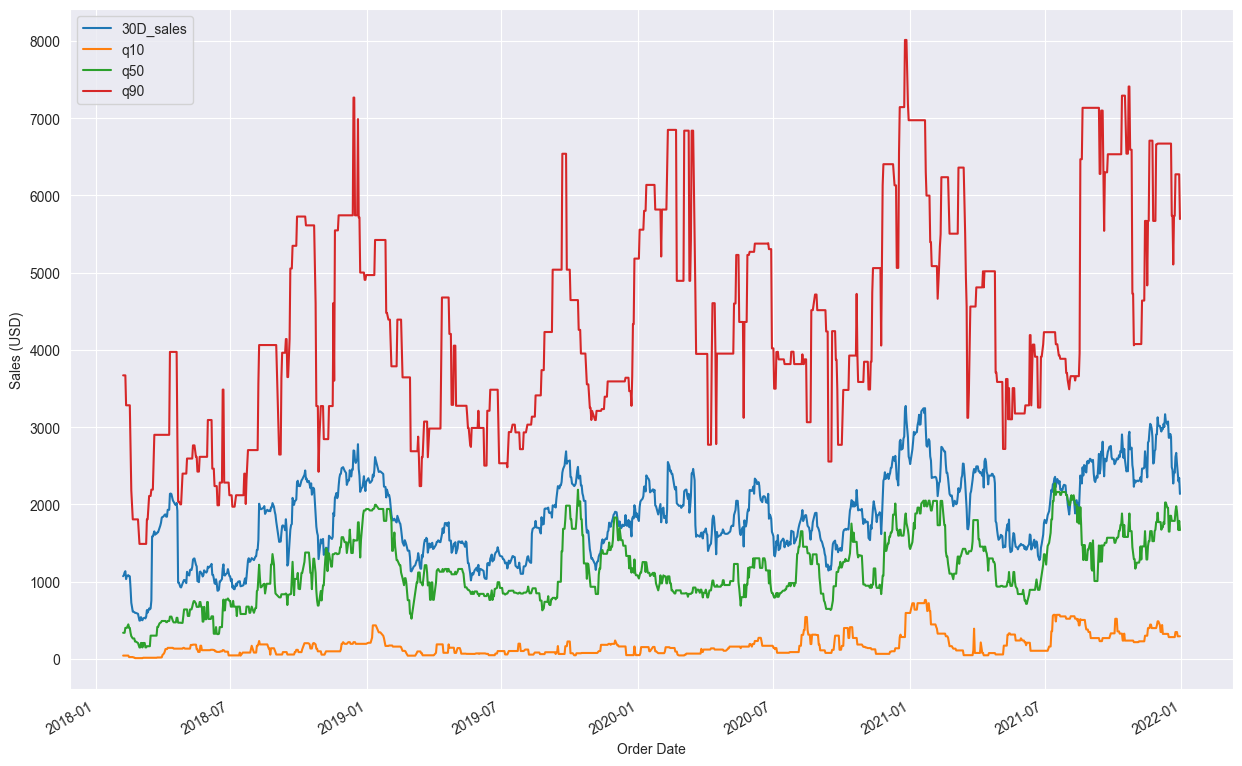

In [49]:
#get subset of data
sales_subset = sales.loc[:,["Sales", "30D_sales"]]

#create rolling average
rolling = sales_subset.Sales.rolling(30)

#calculate quantiles
sales_subset['q10'] = rolling.quantile(0.1).to_frame('q10')
sales_subset['q50'] = rolling.quantile(0.5).to_frame('q50')
sales_subset['q90'] = rolling.quantile(0.9).to_frame('q90')

#plot data
sales_subset[["30D_sales", "q10", "q50", "q90"]].plot()
plt.gcf().set_size_inches(15, 10)
plt.ylabel("Sales (USD)")
plt.show()

##### HeatMap of the Dataset

/var/folders/r0/6jmmwyrj56123vb9rjqcjc6r0000gn/T/ipykernel_5426/1496864016.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_map = sales_raw[sales_raw.columns].corr()


<AxesSubplot: >

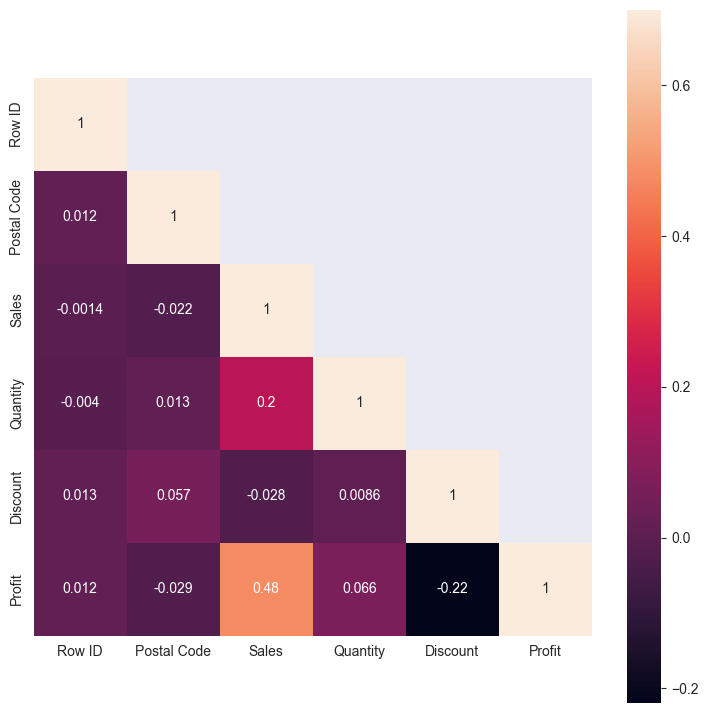

In [51]:
correlation_map = sales_raw[sales_raw.columns].corr()
obj = np.array(correlation_map)
obj[np.tril_indices_from(obj)] = False
fig,ax= plt.subplots()
fig.set_size_inches(9,9)
sns.heatmap(correlation_map, mask=obj,vmax=.7, square=True,annot=True)

Let's create one summary figure with subplots of all the different rolling averages from above:

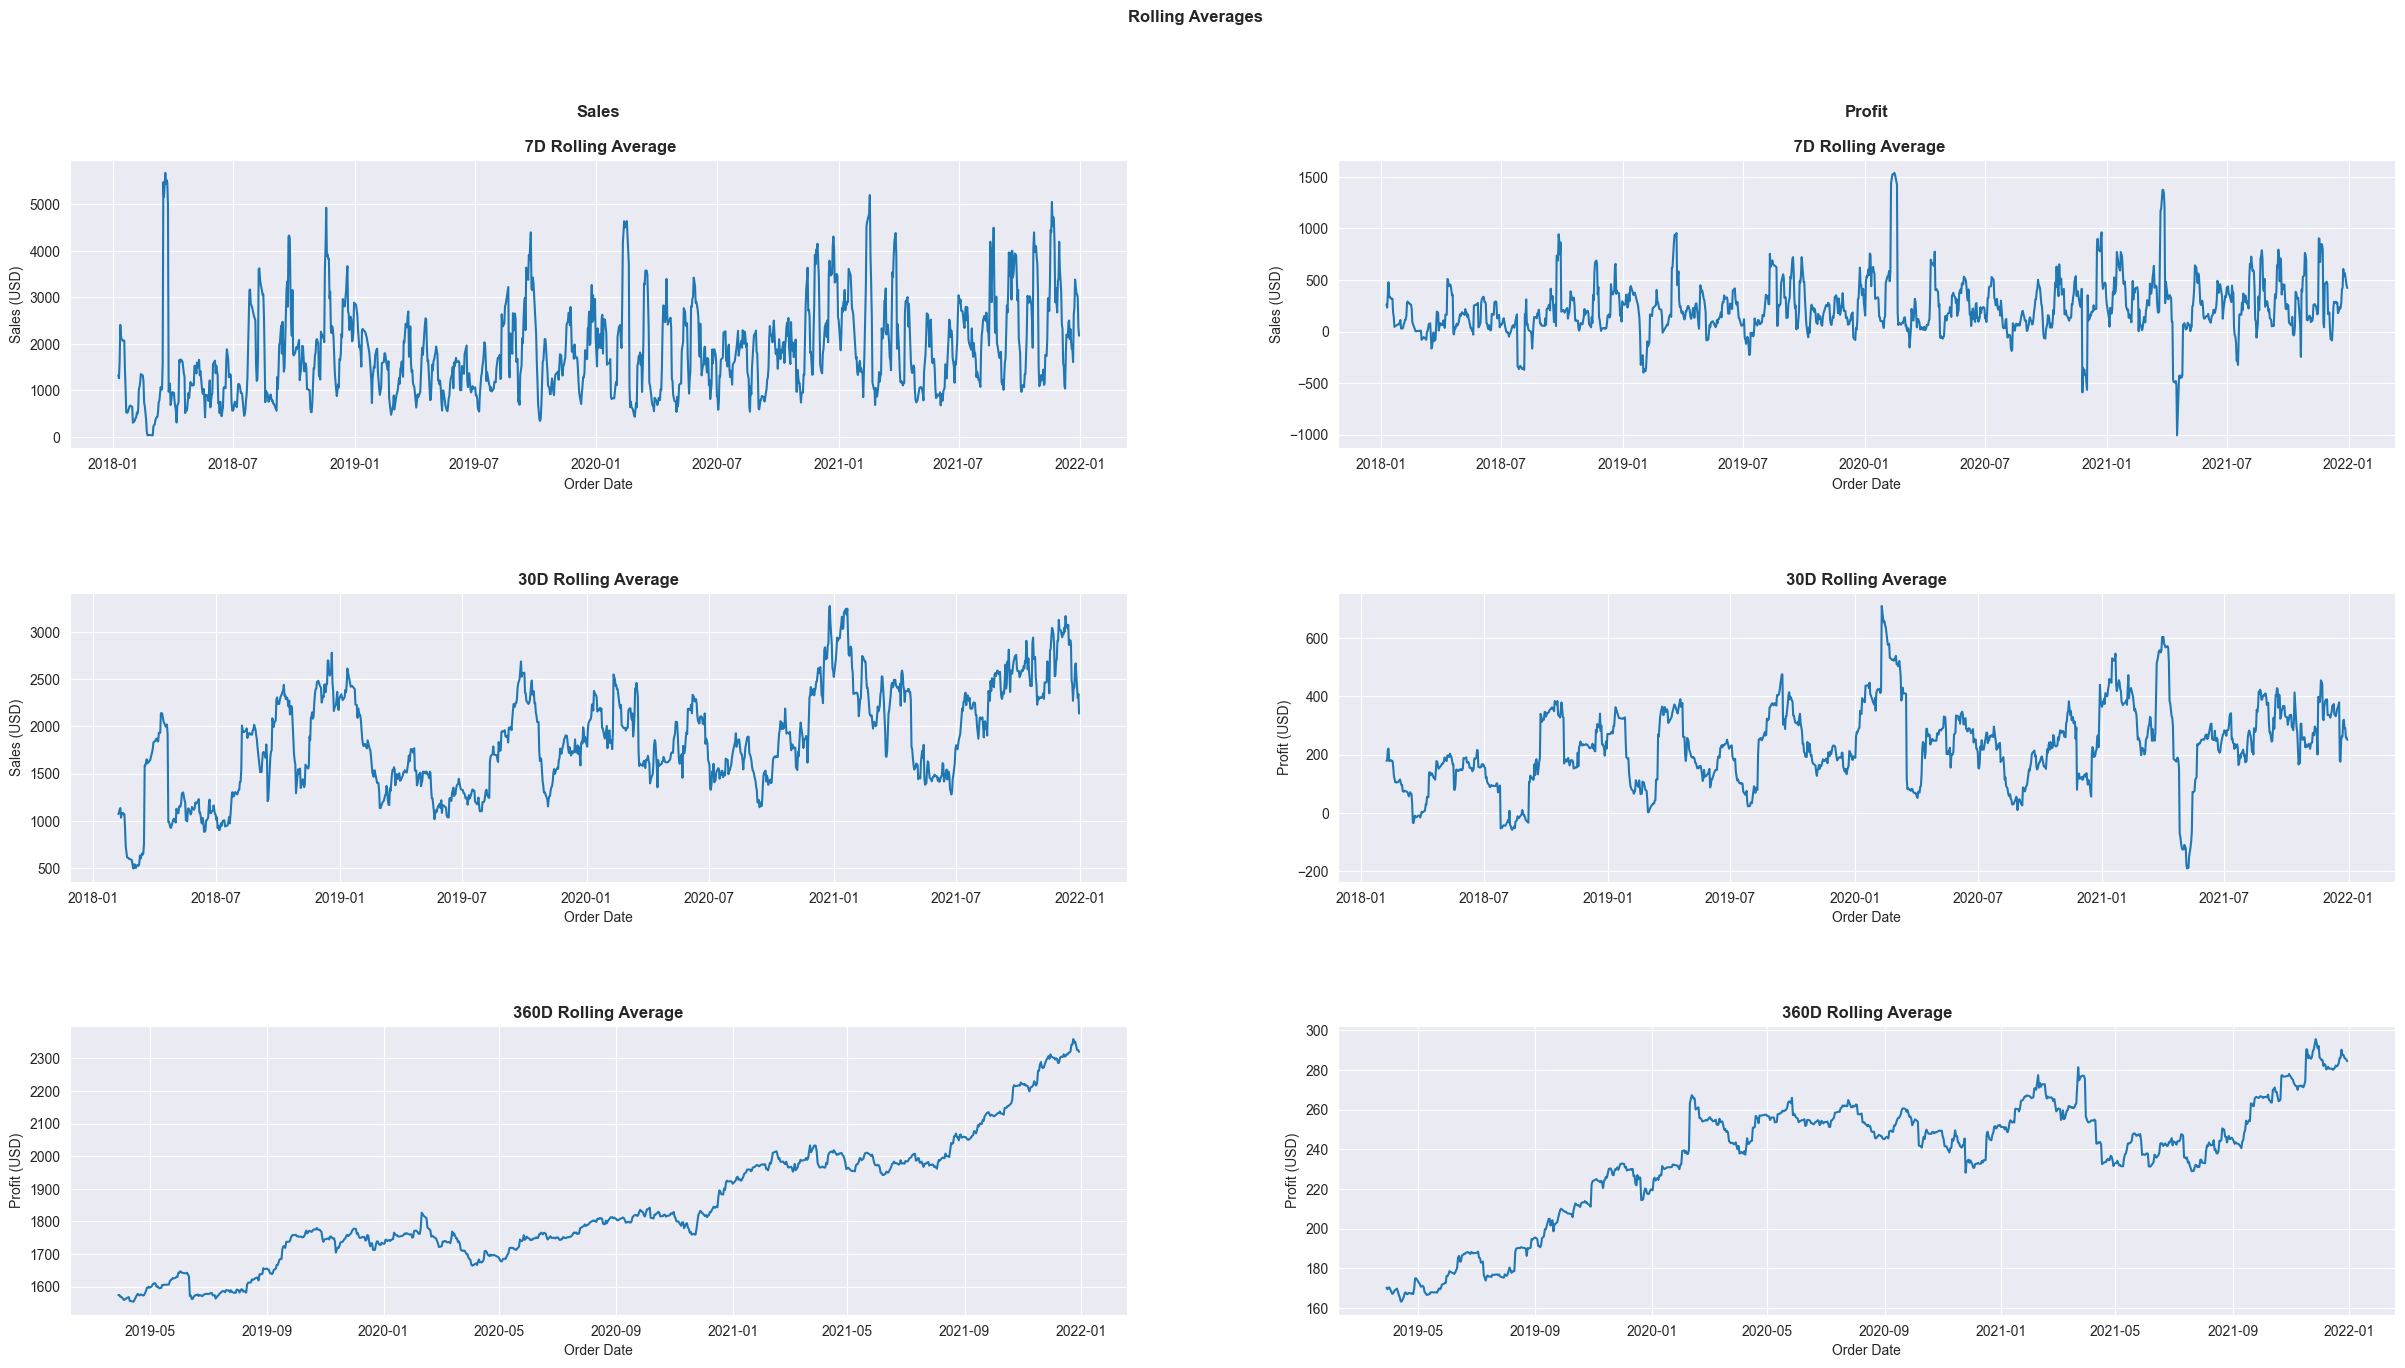

In [50]:
#plot sales percentage change
fig, axes = plt.subplots(3, 2)

sns.lineplot(ax = axes[0, 0], x = sales.index, y = '7D_sales', data = sales)
sns.lineplot(ax = axes[0, 1], x = sales.index, y = '7D_profit', data = sales)
sns.lineplot(ax = axes[1, 0], x = sales.index, y = '30D_sales', data = sales)
sns.lineplot(ax = axes[1, 1], x = sales.index, y = '30D_profit', data = sales)
sns.lineplot(ax = axes[2, 0], x = sales.index, y = '360D_sales', data = sales)
sns.lineplot(ax = axes[2, 1], x = sales.index, y = '360D_profit', data = sales)

fig.suptitle('Rolling Averages', weight='bold')
axes[0,0].set_title("Sales\n\n 7D Rolling Average", weight='bold')
axes[0,1].set_title("Profit\n\n 7D Rolling Average", weight='bold')
axes[1,0].set_title("30D Rolling Average", weight='bold')
axes[1,1].set_title("30D Rolling Average", weight='bold')
axes[2,0].set_title("360D Rolling Average", weight='bold')
axes[2,1].set_title("360D Rolling Average", weight='bold')
axes[0,0].set_ylabel("Sales (USD)")
axes[0,1].set_ylabel("Sales (USD)")
axes[1,0].set_ylabel("Sales (USD)")
axes[1,1].set_ylabel("Profit (USD)")
axes[2,0].set_ylabel("Profit (USD)")
axes[2,1].set_ylabel("Profit (USD)")
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)

#### Observations:

1. Out of all the visualization techniques, the 30-day rolling average is the best. We'll be using that going forward.
2. The rolling 360-day average of sales and profit clearly show an increase in sales and profit overtime, however sales is increase at a scale of almost 10x more. This conclusion, however, could also have been made with the previous data from monthly_sales, etc.

### Rolling Average Percent Change

Let's look at the monthly and yearly percent changes in sales and profit values:

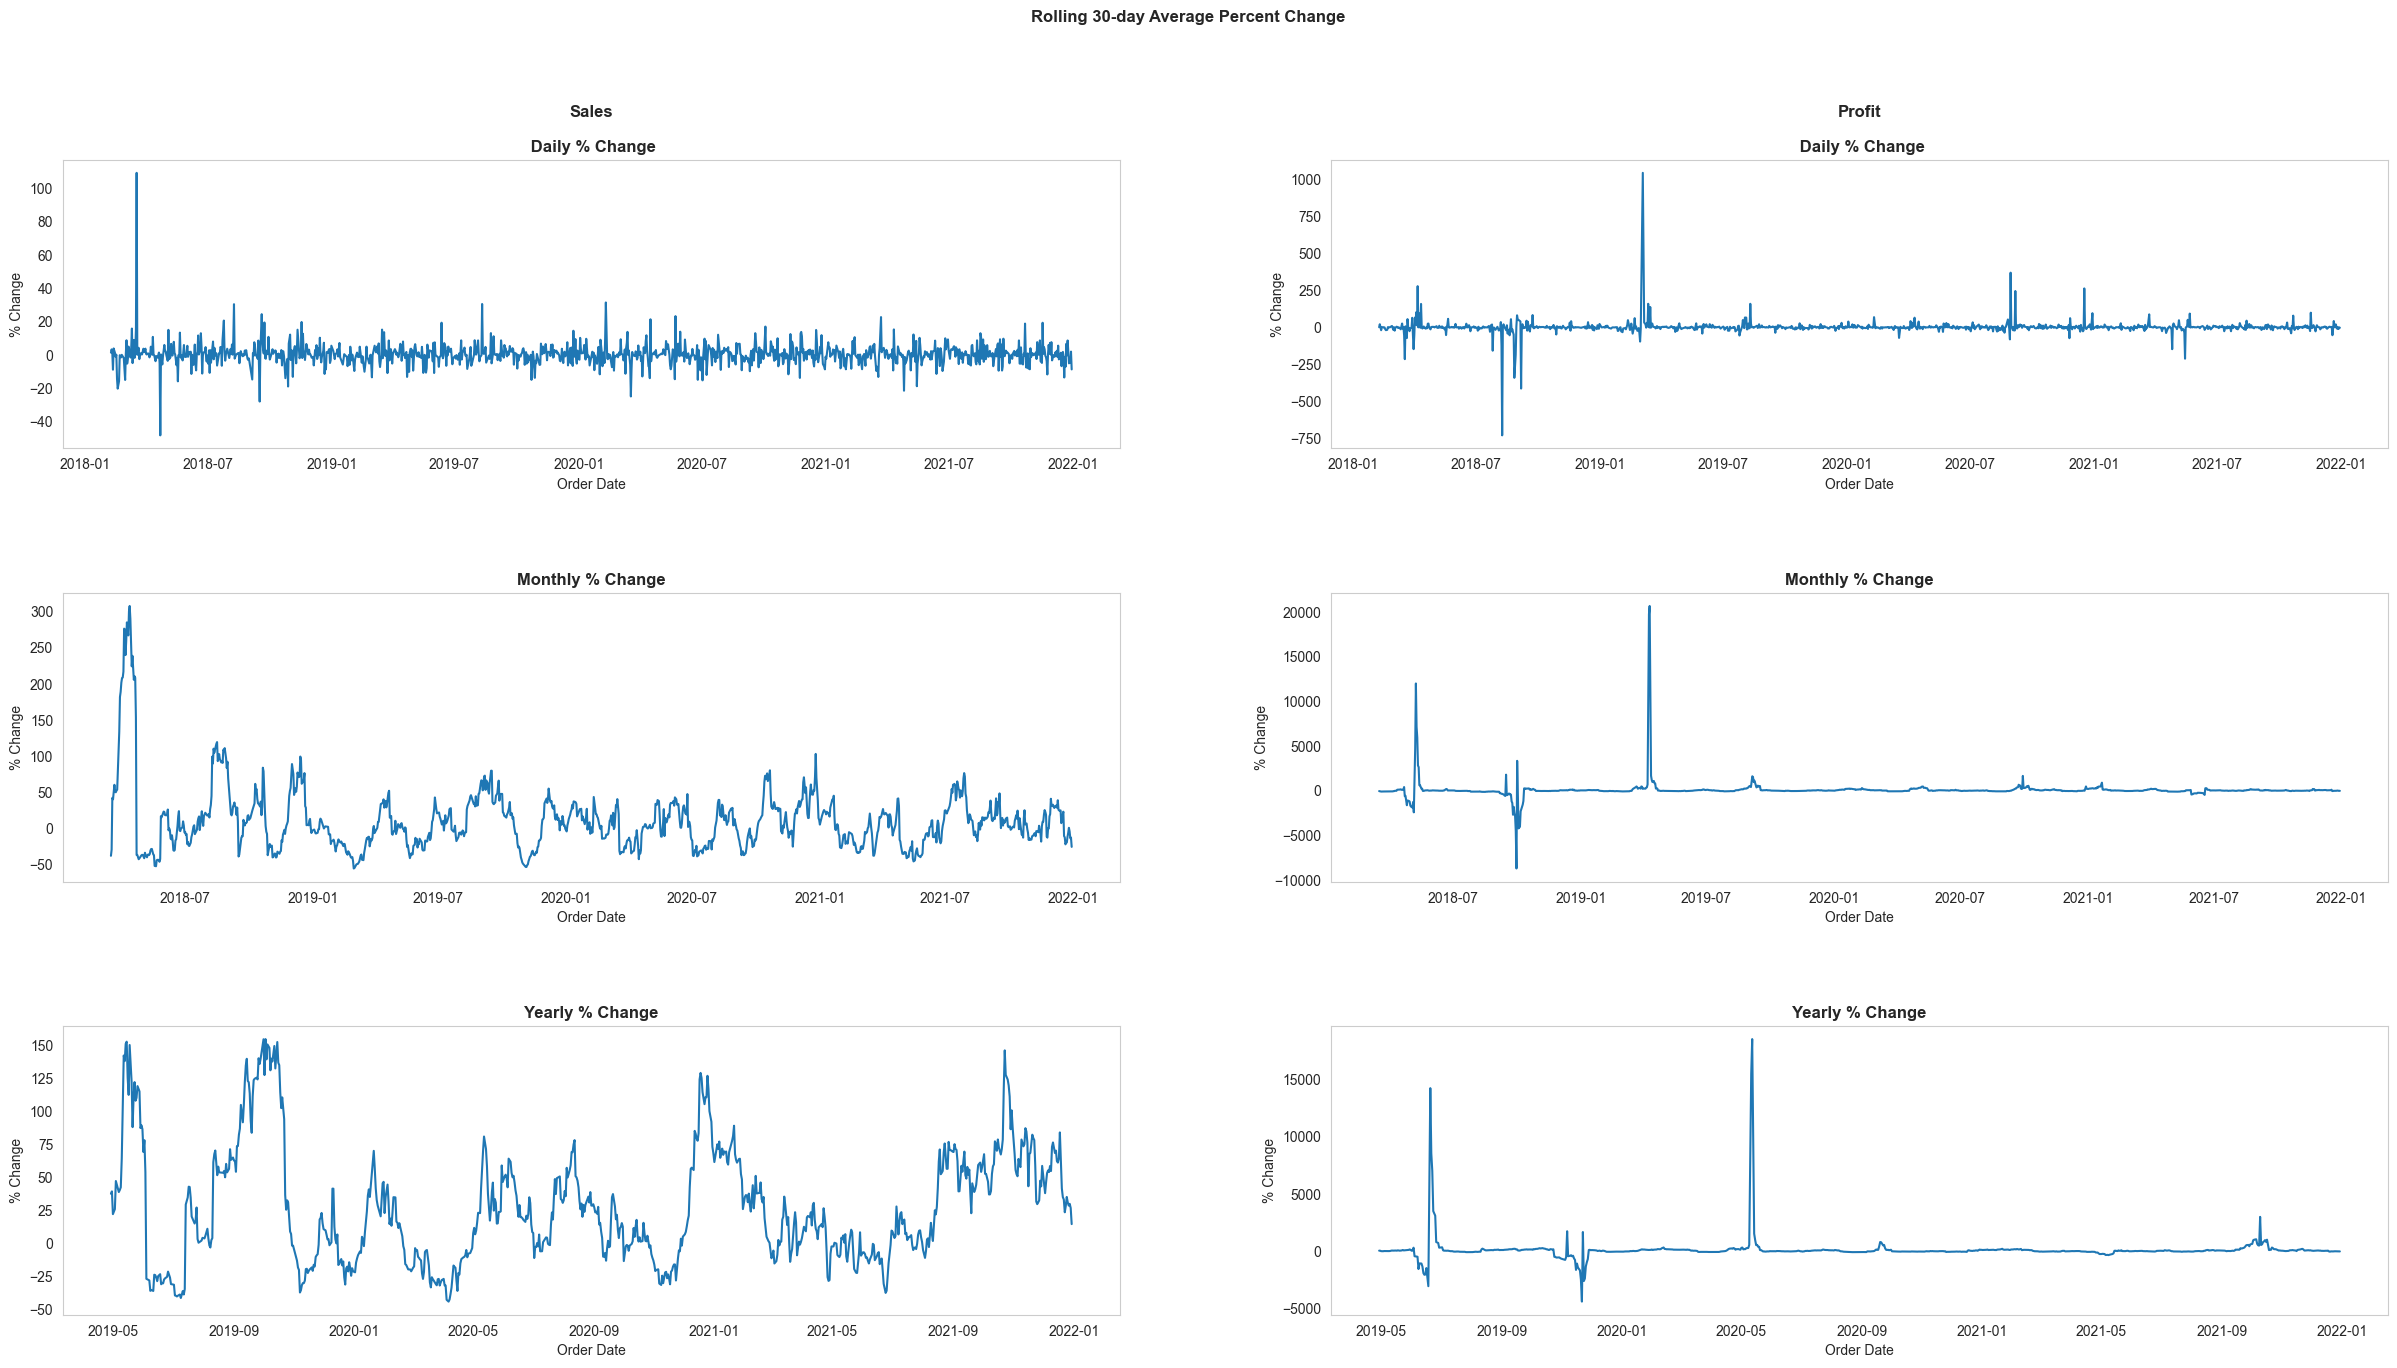

In [55]:
#sales
sales['30D_sales_daily'] = sales['30D_sales'].pct_change(periods = 1).mul(100) #daily
sales['30D_sales_monthly'] = sales['30D_sales'].pct_change(periods = 30).mul(100) #monthly
sales['30D_sales_yearly'] = sales['30D_sales'].pct_change(periods = 360).mul(100) #yearly

#profit
sales['30D_profit_daily'] = sales['30D_profit'].pct_change(periods = 1).mul(100) #daily
sales['30D_profit_monthly'] = sales['30D_profit'].pct_change(periods = 30).mul(100) #monthly
sales['30D_profit_yearly'] = sales['30D_profit'].pct_change(periods = 360).mul(100) #yearly

#plot sales percentage change
fig, axes = plt.subplots(3, 2)

sns.lineplot(ax = axes[0, 0], x = sales.index, y = '30D_sales_daily', data = sales)
sns.lineplot(ax = axes[0, 1], x = sales.index, y = '30D_profit_daily', data = sales)
sns.lineplot(ax = axes[1, 0], x = sales.index, y = '30D_sales_monthly', data = sales)
sns.lineplot(ax = axes[1, 1], x = sales.index, y = '30D_profit_monthly', data = sales)
sns.lineplot(ax = axes[2, 0], x = sales.index, y = '30D_sales_yearly', data = sales)
sns.lineplot(ax = axes[2, 1], x = sales.index, y = '30D_profit_yearly', data = sales)

fig.suptitle('Rolling 30-day Average Percent Change', weight='bold')
axes[0,0].set_title("Sales\n\n Daily % Change", weight='bold')
axes[0,1].set_title("Profit\n\n Daily % Change", weight='bold')
axes[1,0].set_title("Monthly % Change", weight='bold')
axes[1,1].set_title("Monthly % Change", weight='bold')
axes[2,0].set_title("Yearly % Change", weight='bold')
axes[2,1].set_title("Yearly % Change", weight='bold')
axes[0,0].set_ylabel("% Change")
axes[0,1].set_ylabel("% Change")
axes[1,0].set_ylabel("% Change")
axes[1,1].set_ylabel("% Change")
axes[2,0].set_ylabel("% Change")
axes[2,1].set_ylabel("% Change")
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)

#### Observations:

1. The day-to-day percent changes in sales are pretty constant around zero with only one initial spike.
2. he month-to-month and year-to-year percent changes in sales and profit show clear time-based oscillations.

### Correlation Analysis

Looking at the rolling averages, there is clearly some correlation between sales and profit:

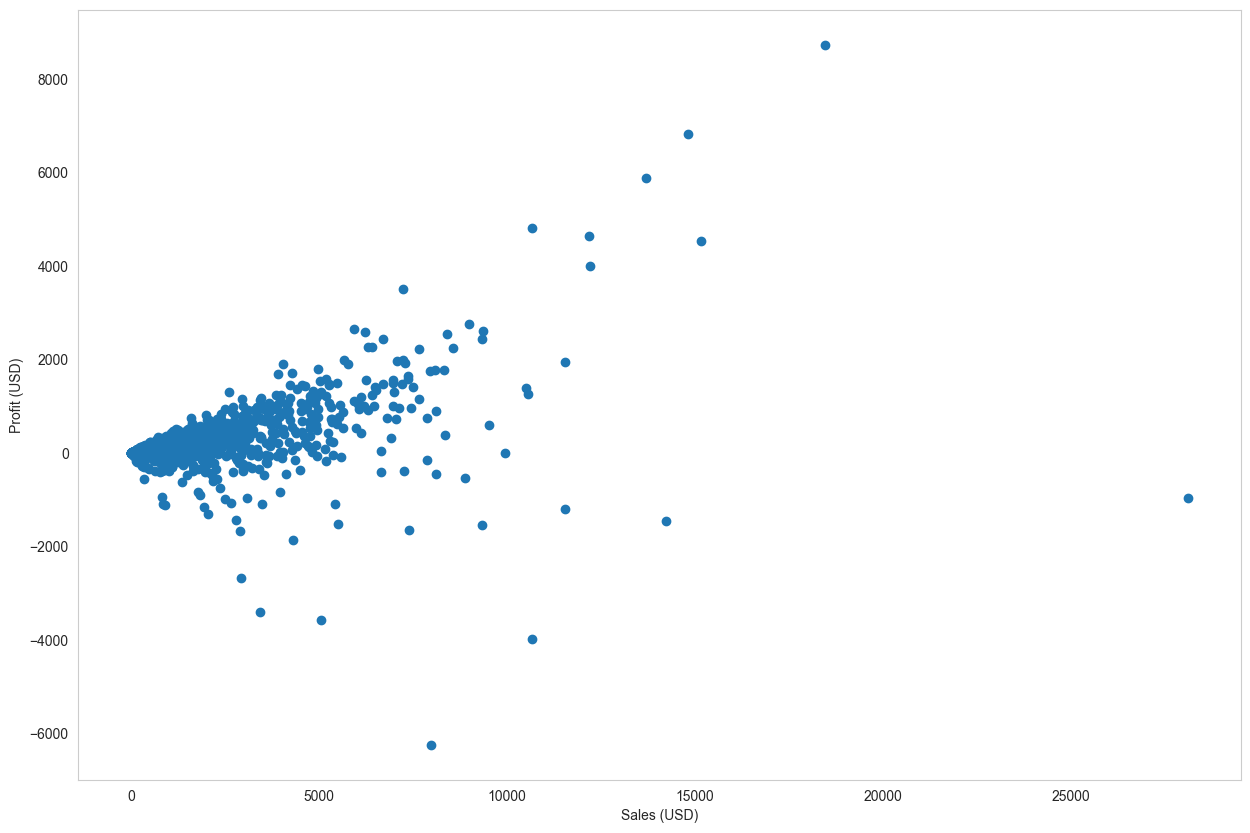

In [56]:
plt.scatter(sales["Sales"], sales["Profit"])
plt.xlabel("Sales (USD)")
plt.ylabel("Profit (USD)")
plt.gcf().set_size_inches(15, 10)
plt.show()

In [57]:
correlation = sales["Sales"].corr(sales["Profit"])
correlation_7D = sales["7D_sales"].corr(sales["7D_profit"])
correlation_30D = sales["30D_sales"].corr(sales["30D_profit"])
correlation_360D = sales["360D_sales"].corr(sales["360D_profit"])

print("Raw data correlation is:", correlation)
print("7D rolling average correlation is:", correlation_7D)
print("30D rolling average correlation is:", correlation_30D)
print("360D rolling average correlation is:", correlation_360D)

Raw data correlation is: 0.4890479818358295
7D rolling average correlation is: 0.5022158000761724
30D rolling average correlation is: 0.574007826349859
360D rolling average correlation is: 0.7373911114344154


#### Observations:

As the rolling average gets larger, the correlation between sales and profits gets stronger.

## Manual Configuration

Now that we'll build our model, let's split the data into training and test sets. The train set will contain the monthly sales data from 2018-2021 and the test set will contain the monthly sales data from 2021-2022

In [58]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = monthly_sales[["Sales"]][:36]
test = monthly_sales[["Sales"]][36:]

#### Order of Differencing (d)

It is obvious that the data is not stationary whether examining the 30-day rolling average of sales or the data from monthly sales. Using the Augmented Dickey Fuller test using adfuller from statsmodel.tsa.stattools, we can verify this. The non-stationary nature of the time series is the null hypothesis. Therefore, if the p-value is more than 0.05, the time series is non-stationary and we have failed to reject the null hypothesis.

In [59]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(monthly_sales["Sales"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.174556
p-value: 0.684444


The p-value is 0.684444 and we fail to reject the null hypothesis, the time series is non-stationary.

We'll do an autocorrelation analysis on the Sales and Profit time series using different rolling averages:

Now let's look at the autocorrelation when using the monthly_sales data. We'll need to use .dropna() to remove the missing values on the .diff() plots:

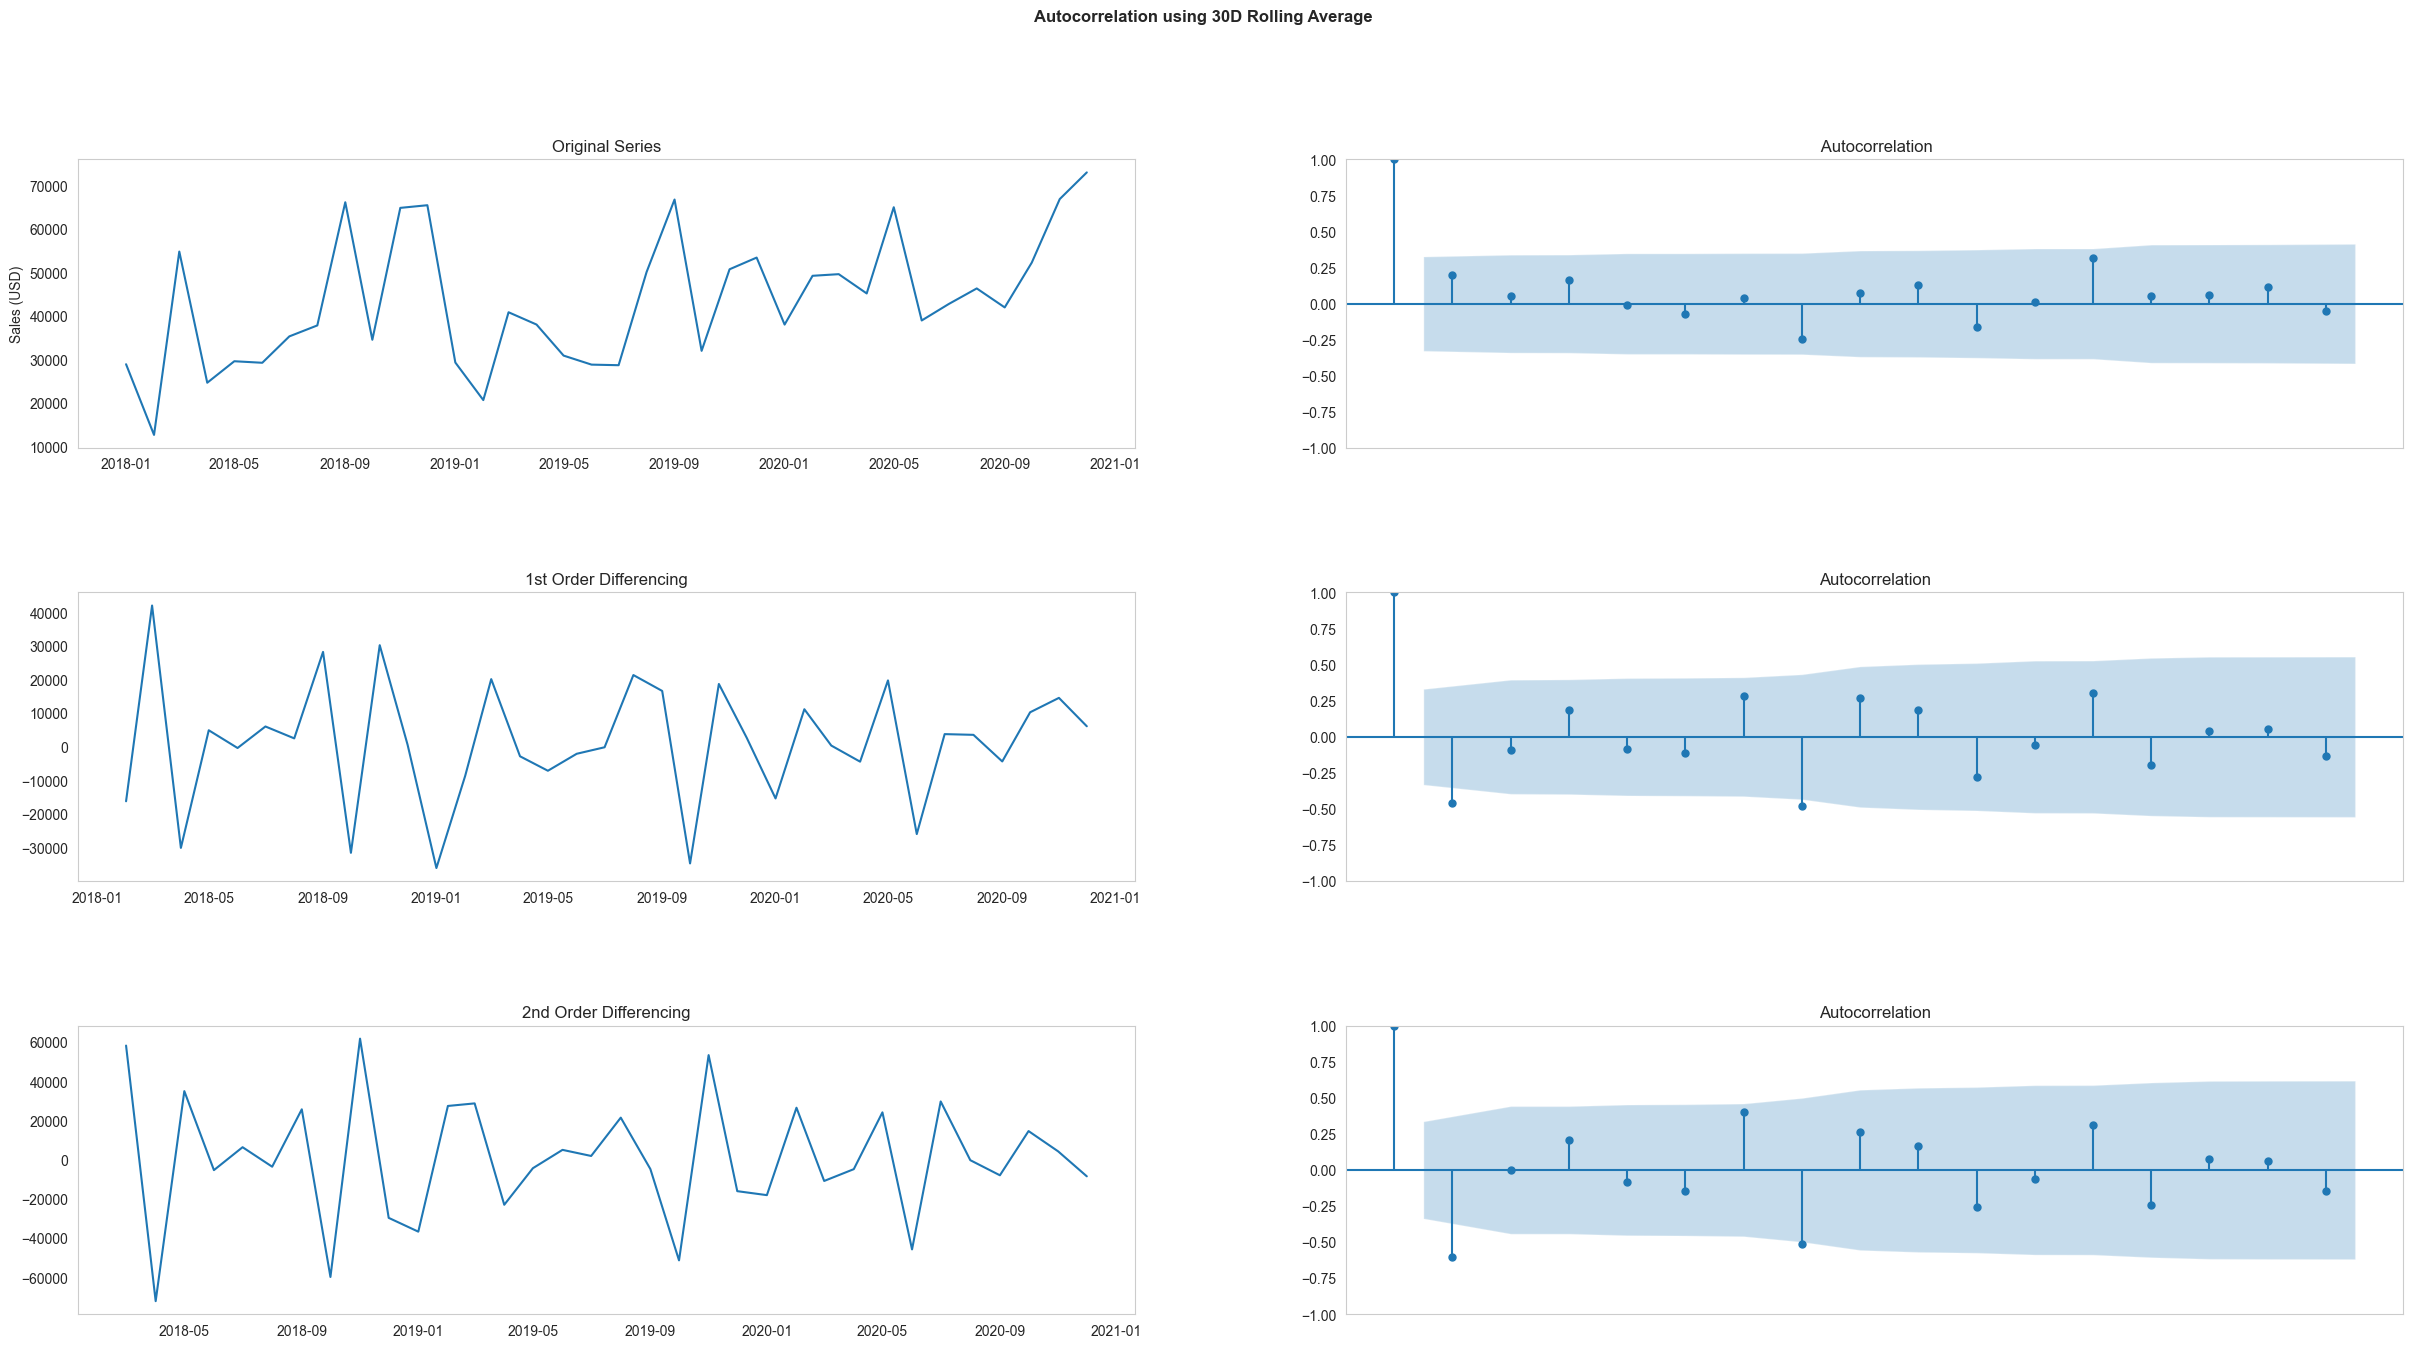

In [60]:
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(3, 2)

#create plot
axes[0, 0].plot(train["Sales"]); axes[0, 0].set_title('Original Series')
plot_acf(train["Sales"], ax=axes[0, 1], title=" Autocorrelation");
axes[1, 0].plot(train["Sales"].diff().dropna()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(train["Sales"].diff().dropna(), ax=axes[1, 1], title="Autocorrelation");
axes[2, 0].plot(train["Sales"].diff().diff().dropna()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(train["Sales"].diff().diff().dropna(), ax=axes[2, 1], title="Autocorrelation");

#visuals
fig.suptitle('Autocorrelation using 30D Rolling Average', weight='bold')
axes[0,0].set_ylabel("Sales (USD)")
axes[1,0].set_ylabel("")
axes[2,0].set_ylabel("")
axes[0,1].set_xticks([])
axes[1,1].set_xticks([])
axes[2,1].set_xticks([])
plt.gcf().set_size_inches(30, 15)
plt.subplots_adjust(hspace=.5)
plt.show()

#### Observations:

1. The p-value of the ADF test is 0.684444 and we fail to reject the null hypothesis, the time series is non-stationary.
2. 1st order differencing created a stationary time series with a constant mean and variance using a lag of 1 (i.e. .diff()).
3. Additional differencing was attempted (i.e 2nd order differencing), however it did not improve the autocorrelation (see lag multiples of 3).
4. Order of differencing is 1

#### AR term (p):

/Users/tejaspatel/IdeaProjects/capstone_retail_predictor/venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


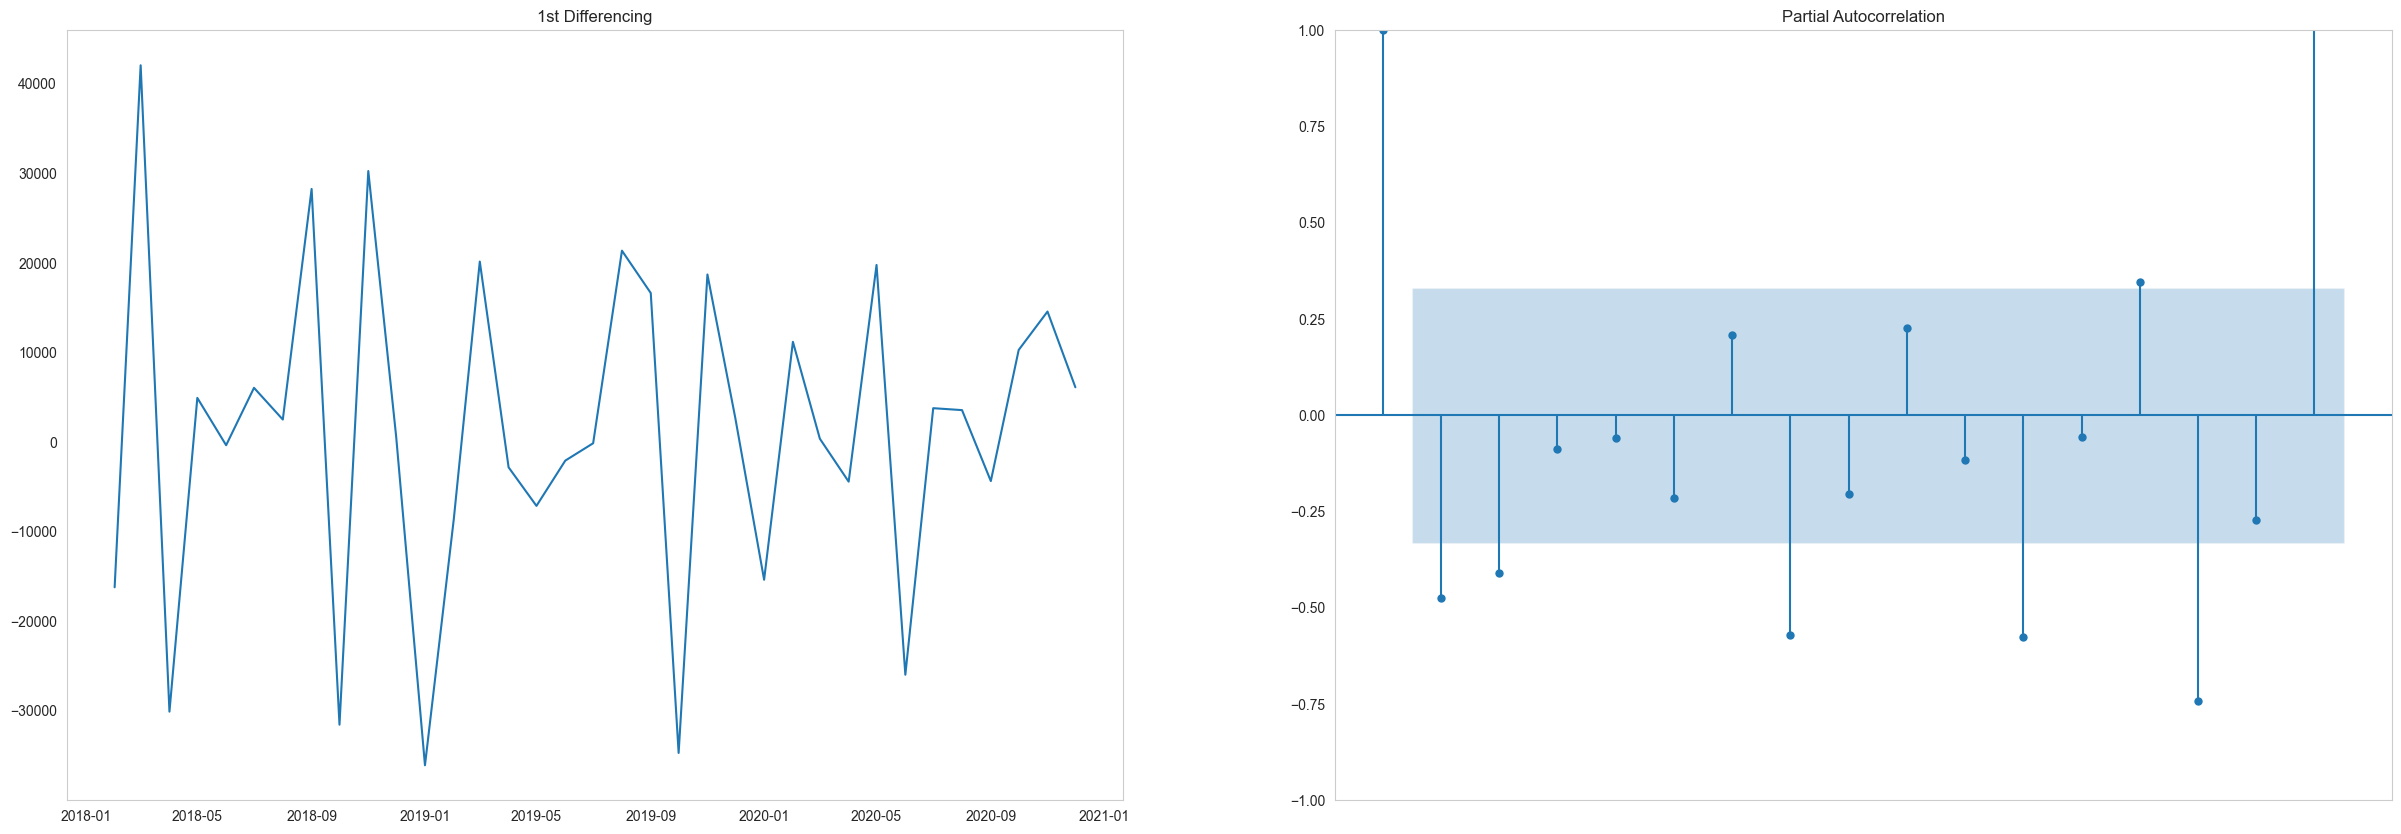

In [61]:
from statsmodels.graphics.tsaplots import plot_pacf

#create figures
fig, axes = plt.subplots(1, 2)
axes[0].plot(train["Sales"].diff()); axes[0].set_title('1st Differencing')
plot_pacf(train["Sales"].diff().dropna(), ax=axes[1])

#visuals
plt.gcf().set_size_inches(30, 10)
plt.xticks([])
plt.show()

Lag 19 is significantly different from zero. However, the other lags are not. We will conservatively set lag to 2

### MA term (q):

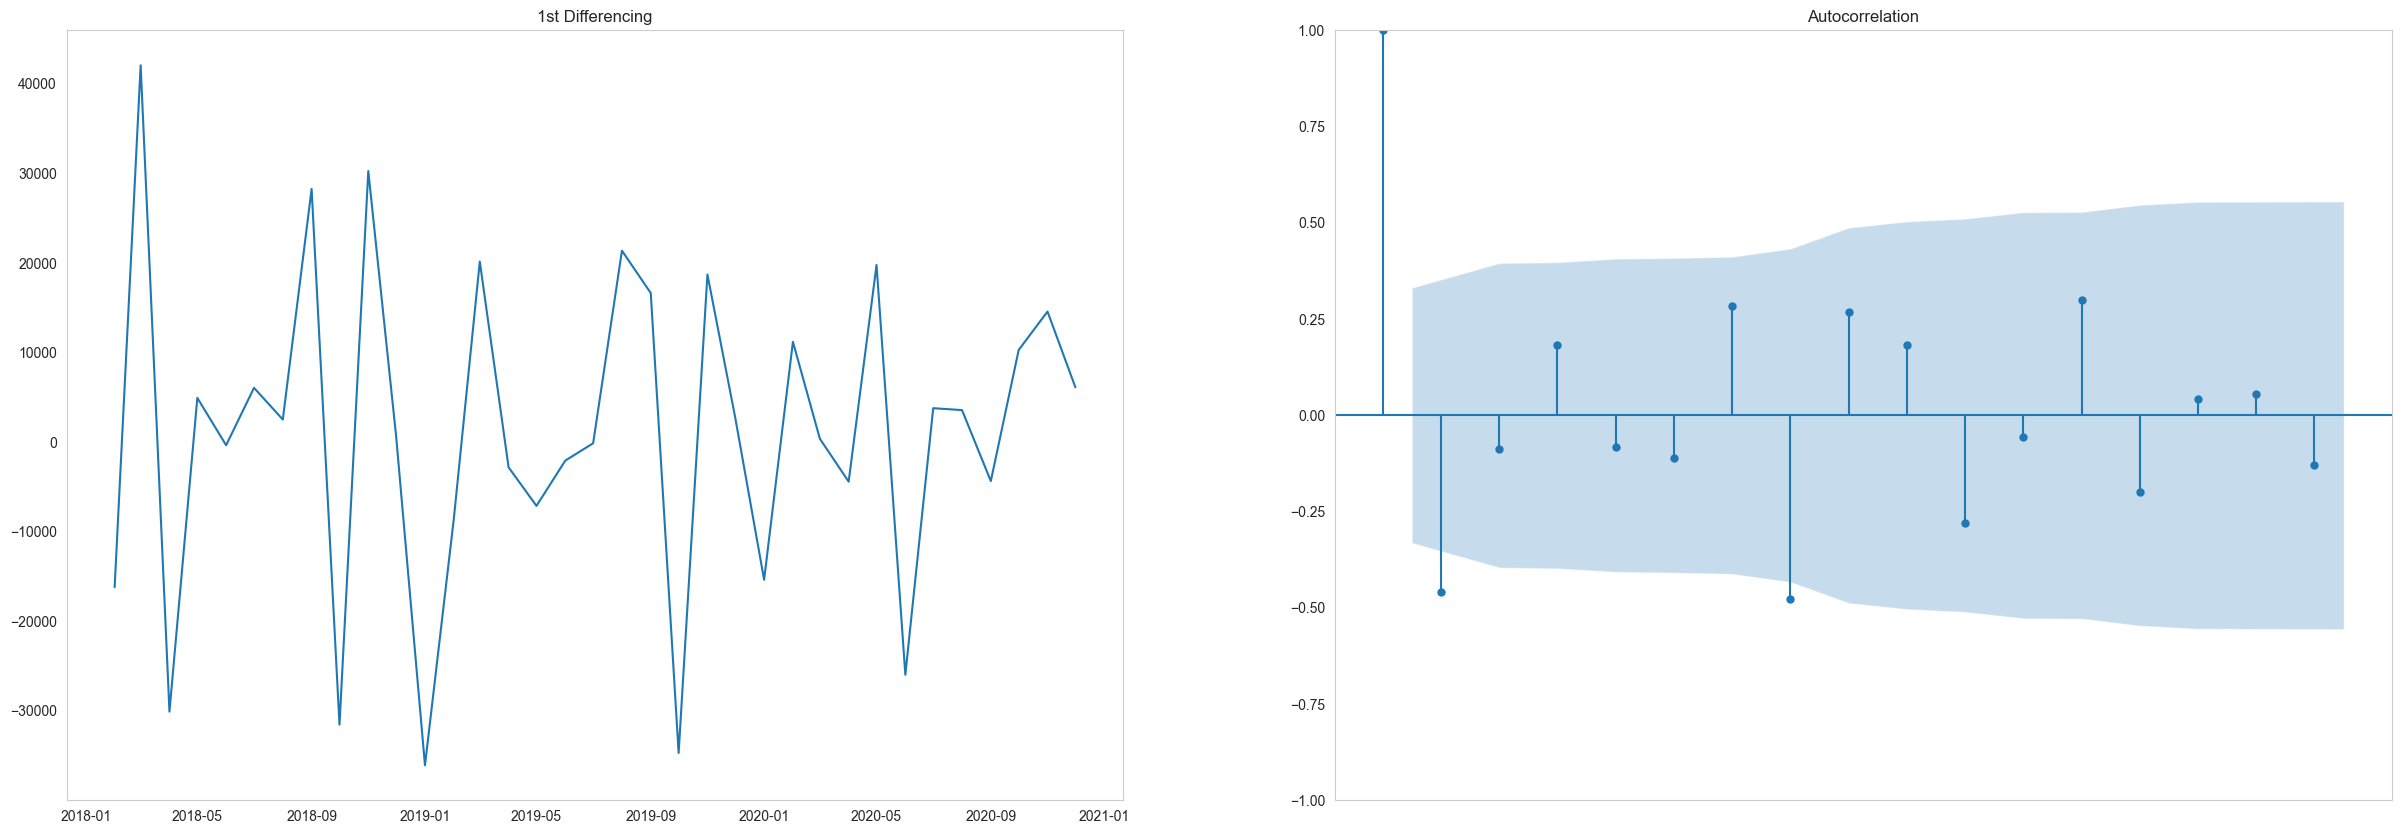

In [63]:
fig, axes = plt.subplots(1, 2)

axes[0].plot(train["Sales"].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(train["Sales"].diff().dropna(), ax=axes[1])
plt.gcf().set_size_inches(30, 10)
axes[1].set_xticks([])
plt.show()

#### Observations:

1. None of the lines are above the blue line by a large amount. We'll set the MA term q = 0.
2. The ARIMA model will be built with terms: p, d, q = 2, 1, 0

Now we will finally fit the Sales time series to an ARIMA model:

In [66]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# order=(p, d, q)
model = ARIMA(train["Sales"], order=(2, 1, 0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(2, 1, 0)   Log Likelihood                -387.652
Date:                Tue, 18 Oct 2022   AIC                            781.303
Time:                        12:19:10   BIC                            785.969
Sample:                    01-01-2018   HQIC                           782.914
                         - 12-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5879      0.123     -4.786      0.000      -0.829      -0.347
ar.L2         -0.2586      0.128     -2.019      0.043      -0.510      -0.008
sigma2      2.017e+08    2.2e-10   9.17e+17      0.0

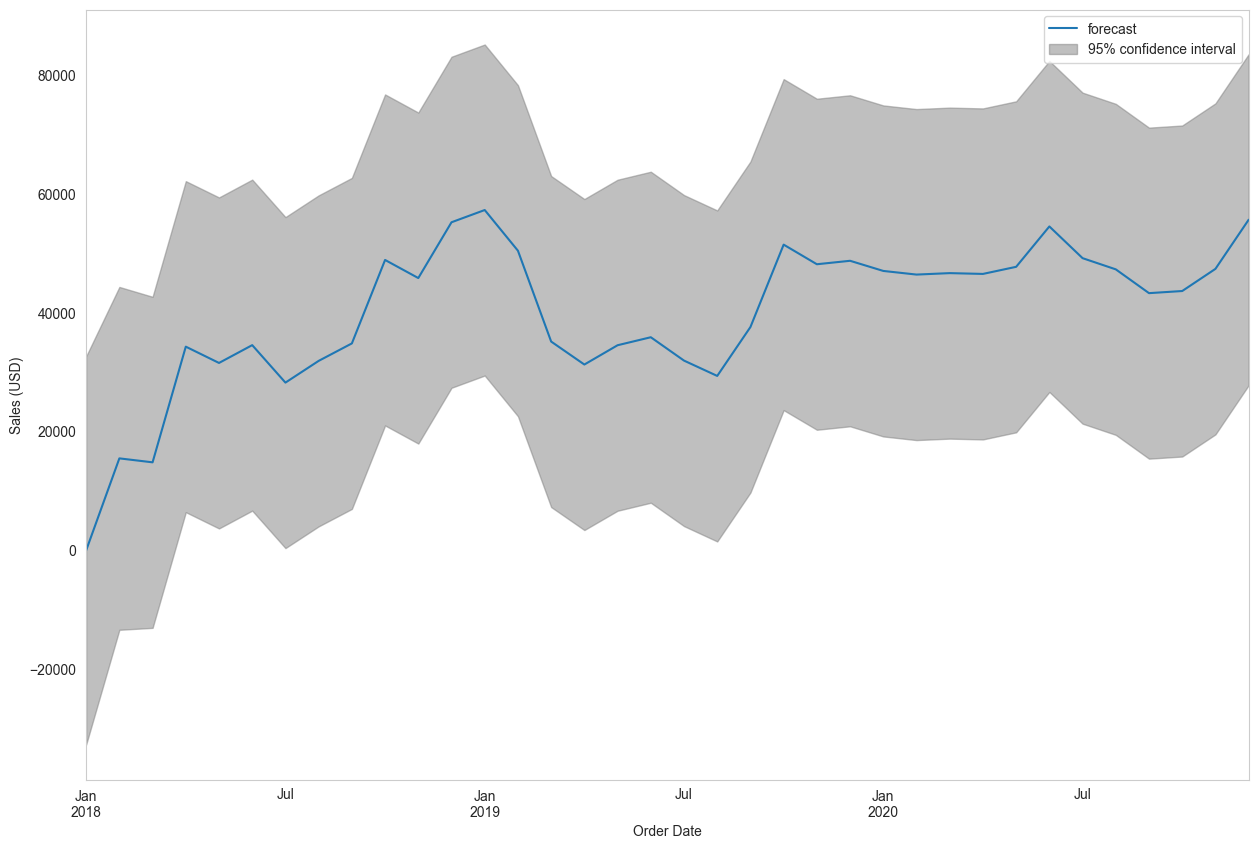

In [68]:
from statsmodels.graphics.tsaplots import plot_predict
plot_predict(model_fit,dynamic=False)
plt.ylabel("Sales (USD)")
plt.gcf().set_size_inches(15, 10)
plt.show()

In [69]:
# from sklearn.metrics import mean_squared_error
#
# #Import the test data, format as an array
# validation = pd.read_csv('/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/test.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# y = validation.values.astype('float32')
#
# #Import the training data, format as an array
# dataset = pd.read_csv('/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/train.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# X = dataset.values.astype('float32')
#
# history = [x for x in X] #Create a list of all training data
# months_in_year = 12
# predictions=list()
# yhat = float(model_fit.forecast()[0])
# yhat = inverse_difference(history, yhat, months_in_year)
# predictions.append(y[0])
# history.append(y[0])
# print(f'Predicted: {yhat:.3f}, Expected: {y[0]:.3f}') #output first month's performance
#
# #loop through all months and calculate performance
# for i in range(1, len(y)):
#     months_in_year = 12
#     diff = difference(history, months_in_year) #account for seasonality
#     model = ARIMA(diff, order=(2, 1, 0)) #create ARIMA model
#     model_fit = model.fit() #fit model
#     yhat = model_fit.forecast()[0] #get prediction value
#     yhat = inverse_difference(history, yhat, months_in_year) #reverse the difference to get value
#     predictions.append(yhat) #add predicted value to list
#     # observation
#     obs = y[i]
#     history.append(obs)
#     print('Predicted: %.3f, Expected: %.3f' % (yhat, obs))
#
# # report performance
# rmse = np.sqrt(mean_squared_error(y, predictions))
# print('\nRMSE: %.3f' % rmse)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Grad School/INFO 659/SuperstoreSalesPredictor/data/test.csv'